# Data extraction and analysing

### Libraries and functions

In [3]:
'''import pyspark as ps
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import asc
from pyspark.sql import functions as F
from pyspark.sql import HiveContext
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from multiprocessing import Pool, Manager, Process
import multiprocessing
import os
import time
import numpy as np
'''ps.SparkContext.setSystemProperty('spark.executor.memory', '25g')
ps.SparkContext.setSystemProperty('spark.dynamicAllocation.maxExecutor', '1')
try:
   sc.stop()
except NameError:
   pass
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.3.0 pyspark-shell'
conf = ps.SparkConf().setMaster('local')
sc = ps.SparkContext(conf=conf)
sql = ps.SQLContext(sc)
hive = HiveContext(sc)'''

"ps.SparkContext.setSystemProperty('spark.executor.memory', '25g')\nps.SparkContext.setSystemProperty('spark.dynamicAllocation.maxExecutor', '1')\ntry:\n   sc.stop()\nexcept NameError:\n   pass\nos.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.3.0 pyspark-shell'\nconf = ps.SparkConf().setMaster('local')\nsc = ps.SparkContext(conf=conf)\nsql = ps.SQLContext(sc)\nhive = HiveContext(sc)"

In [4]:
# Language detection tools

import nltk

import polyglot
from polyglot.detect import Detector
from polyglot.text import Sentence
from polyglot.text import Text

import langdetect
from langdetect import detect_langs
from langdetect import DetectorFactory
DetectorFactory.seed = 0

def polyglot_detect(sentence):
    lang_list = []
    for language in Detector(sentence).languages:
        lang_list.append(str(language))
    return lang_list

def langdetect_detect(sentence):
    return detect_langs(sentence)

def all_lang_detect(text):
    
    try:
        poly = polyglot_detect(text)
    except:
        poly = 'NA'
    try:
        langdet = langdetect_detect(text)
    except:
        langdet = []
    poly_res = {}
    if (poly != 'NA'):
        for j in range(3):
            res = poly[j][poly[j].find('code:') + len('code: '):poly[j].find('confidence:')].strip()
            if res != 'un':
                poly_res[res] = str(float(poly[j][poly[j].find('confidence:') + len('confidence:  '):poly[j].find('read bytes:')].strip())/100)
            else:
                break   

    langdet_res = {}
    if len(langdet) > 0:
        j = -1
        while j > -2:
            j += 1
            try:
                langdet_res[langdet[j].lang] = langdet[j].prob
            except:
                break
    
    return poly_res, langdet_res

# Find all languages in instances

def lang_detect(text):
    poly_res_dict, langdet_res_dict = all_lang_detect(text)
    poly_res = list(poly_res_dict.keys())
    langdet_res = list(langdet_res_dict.keys())
    if len(poly_res) > 0 or len(langdet_res) > 0:
        return list(set(poly_res + langdet_res))    
    return None    

ModuleNotFoundError: No module named 'icu'

In [63]:
def cleaning_sent(cond, text):
    t = re.compile('[^' + '|'.join(cond) + ']')
    return re.sub(t, '', text)

def get_condition_characters_list():
    cond = u'Á|á|Ð|ð|É|Ó|Ú|Ý|ý|Þ|þ|ú|ó|é|ä|Ä|ö|Ö|Š|š|Ž|ž|Ü|Į|į|ü|Ā|Č|Ē|Ģ|Ī|Ķ|Ļ|Ņ|Ū|ā|č|ē|ģ|ī|ķ|ļ|ņ|Ę|ę|Ė|ė|Ą|ą|Ų|ų|Æ|Ø|Å|æ|ø|å '
    cond = cond.split('|')
    cond += [chr(k) for k in [i for i in range(65, 91)] + [j for j in range(97, 123)]]
    cond += [u'й', u'ц', u'у', u'к', u'е', u'н', u'г', u'ш', u'щ', u'з', u'х', u'ъ', u'ф', u'ы', u'в', u'а', u'п', u'р',
             u'о', u'л', u'д', u'ж', u'э', u'я', u'ч', u'с', u'м', u'и', u'т', u'ь', u'б', u'ю', u'Й', u'Ц', u'У', u'К',
             u'Е', u'Н', u'Г', u'Ш', u'Щ', u'З', u'Х', u'Ъ', u'Ф', u'Ы', u'В', u'А', u'П', u'Р', u'О', u'Л', u'Д', u'Ж',
             u'Э', u'Я', u'Ч', u'С', u'М', u'И', u'Т', u'Ь', u'Б', u'Ю', ' ']
    return cond

# Language separation function

def language_detection_with_sent(text):
    if str(text).lower() != 'nan' and str(text) != 'Null':
        words = nltk.sent_tokenize(text)
    else:
        return
    cond = get_condition_characters_list()    
    langs = []
    probabs = [[] for k in range(100)]
    texts = [[] for k in range(100)]
    flag = 0
    for i in range(0, len(words)):
        old_w = words[i] 
        w = cleaning_sent(cond, old_w)
        poly_res_dict, langdet_res_dict = all_lang_detect(w.lower())
        poly_res = list(poly_res_dict.keys())
        langdet_res = list(langdet_res_dict.keys())
        poly_val = list(poly_res_dict.values())
        langdet_val = list(langdet_res_dict.values())
        if len(poly_res) != 0:
            if poly_res[0] == langdet_res[0]:
                if poly_res[0] not in langs:
                    langs.append(poly_res[0])
                j = langs.index(poly_res[0])
                texts[j].append(w)
                probabs[j].append(poly_val[0])
                flag = 1
            else:
                if poly_val[0] > langdet_val[0]:
                    if poly_res[0] not in langs:
                        langs.append(poly_res[0])
                    j = langs.index(poly_res[0])
                    texts[j].append(w)
                    probabs[j].append(poly_val[0])
                    flag = 1
                else:
                    if langdet_res:
                        if langdet_res[0] not in langs:
                            langs.append(langdet_res[0])            
                        j = langs.index(langdet_res[0])
                        texts[j].append(w)
                        probabs[j].append(langdet_val[0])
                        flag = 1
        if flag == 0:
            if langdet_res:
                if langdet_res[0] not in langs:
                    langs.append(langdet_res[0])
                j = langs.index(langdet_res[0])
                texts[j].append(w)
                probabs[j].append(langdet_val[0])
    
    for i in range(len(texts)):
        txt = ''.join(texts[i])
        if not txt.strip():
            texts[i] = ''
    
    most_frequent_lang_indices = np.lexsort(([-k for k in range(len(texts))], [len(texts[k]) for k in range(len(texts))]))[-3:][::-1]
 
    y = dict()
    y['Language1'] = langs[most_frequent_lang_indices[0]] if len(langs) > most_frequent_lang_indices[0] else None    
    y['Language2'] = langs[most_frequent_lang_indices[1]] if len(langs) > most_frequent_lang_indices[1] else None    
    y['Language3'] = langs[most_frequent_lang_indices[2]] if len(langs) > most_frequent_lang_indices[2] else None
    y['Probability1'] = np.mean(np.array(probabs[most_frequent_lang_indices[0]]).astype(float)) if probabs[most_frequent_lang_indices[0]] else None
    y['Probability2'] = np.mean(np.array(probabs[most_frequent_lang_indices[1]]).astype(float)) if probabs[most_frequent_lang_indices[1]] else None
    y['Probability3'] = np.mean(np.array(probabs[most_frequent_lang_indices[2]]).astype(float)) if probabs[most_frequent_lang_indices[2]] else None
    y['Text1'] = " ".join(texts[most_frequent_lang_indices[0]]) if texts[most_frequent_lang_indices[0]] else None
    y['Text2'] = " ".join(texts[most_frequent_lang_indices[1]]) if texts[most_frequent_lang_indices[1]] else None
    y['Text3'] = " ".join(texts[most_frequent_lang_indices[2]]) if texts[most_frequent_lang_indices[2]] else None
    
    if y['Probability1'] < 0.01:
        y['Probability1'] = None
    else:
        y['Probability1'] = str(y['Probability1'])
    if y['Probability2'] < 0.01:
        y['Probability2'] = None
    else:
        y['Probability2'] = str(y['Probability2'])
    if y['Probability3'] < 0.01:
        y['Probability3'] = None
    else:
        y['Probability3'] = str(y['Probability3'])
        
    if y['Text1'] is not None and not y['Text1'].strip():
        y['Text1'] = None
    if y['Text2'] is not None and not y['Text2'].strip():
        y['Text2'] = None
    if y['Text3'] is not None and not y['Text3'].strip():
        y['Text3'] = None
        
    if y['Language1'] is not None and not y['Language1'].strip(): 
        y['Language1'] = None
    if y['Language2'] is not None and not y['Language2'].strip():
        y['Language2'] = None
    if y['Language3'] is not None and not y['Language3'].strip():
        y['Language3'] = None
    
    return [y['Language1'], y['Language2'], y['Language3'], y['Probability1'], y['Probability2'], y['Probability3'], y['Text1'], y['Text2'], y['Text3']]

In [3]:
# Functions for n-quads extraction and performing

def getTriple(row):
    triple = row[1:-1].split("\t")
    if len(triple) == 1:
        return None
    else:
        parts = triple[1].split(">, <")
        if len(parts) != 4:
            return None
        return parts
    
def remove_language_strings(sku):
    parts = sku.split("@")
    language_tag = parts[-1]
    # case 1: @et or @fi at the end
    if len(language_tag) == 2:
        sku = "@".join(parts[:-1])
    # case 2: @et-ee at the end
    elif len(language_tag) == 5:
        if language_tag[2] == "-":
            sku = "@".join(parts[:-1])
    return sku

def remove_tab(string):
    new_string = string.replace("\\n",'').replace("\\t",'')
    return new_string

def parse_dict(d):
    for k in d.keys():
        kk = k.split("!")
        extracted_data.loc[extracted_data.index[int(kk[1])], kk[0]] = d[k]
        
def process_stuff(indices, d):
    res = []
    for i in indices:
        link = str(pandas.loc[pandas.index[i], '_1'])
        node = str(pandas.loc[pandas.index[i], '_2'])
        char = str(pandas.loc[pandas.index[i], '_3']).lower()
        descr = str(pandas.loc[pandas.index[i], '_4'])
        node_raw = node[node.find('_:') + len('_:'):len(node)].strip()
        index = extracted_data.index[extracted_data['node'] == node_raw]
        s = char[char.find('product/') + len('product/'):len(char)].strip()
        tag = re.sub(r'[^\w\s]','', s)
        data = descr[descr.find(':node') + len(':'):len(descr)]
        data = remove_language_strings(data)
        new_data = remove_tab(data)
        if tag in extracted_data.columns:
            index = int(index[0])
            d[tag + "!" + str(index)] = new_data
            d['link!' + str(index)] = link
        else:
            print(s, char)
    return True

In [7]:
# Draft second plan
#triples.filter(lambda a: "'http://www.w3.org/1999/02/22-rdf-syntax-ns#type" == a[2].lower()).take(10)
#triples.filter(lambda a: "http://schema.org/product" == a[3].lower())

PythonRDD[11] at RDD at PythonRDD.scala:43

### N-quads extraction

In [2]:
# Extract n-quads as DF
    
triples = sc.textFile("/data/microdata/2017/08").map(getTriple).filter(lambda a: a is not None)
extracted = triples.filter(lambda a: "schema.org/product" in a[2].lower())
DF=sql.createDataFrame(extracted)
pandas = DF.toPandas()
pandas.to_csv("pandas.csv")

In [2]:
# Read ready n-quads DF
import pandas as pd
pandas = pd.read_csv("pandas.csv")
pandas.columns = ['Link', 'Node', 'Characteristic', 'Content']
pandas.head(5)

FileNotFoundError: File b'pandas.csv' does not exist

### Creating of new dataframe

In [25]:
# Extract names of columns from _3 column

tags = []
col_name = pandas['_3']
for j in range(len(col_name)):
    text = col_name[j].lower()
    s = text[text.find('product/') + len('product/'):len(text)].strip()
    tag = re.sub(r'[^\w\s]','', s)
    tags.append(tag)
    
columns = ["link", "node"]
columns = columns + list(set(tags))
columns

['link',
 'node',
 'comment',
 'author',
 'weight',
 'color',
 'image',
 'height',
 'isrelatedto',
 'potentialaction',
 'ratingvalue',
 'logo',
 'desc',
 'availability',
 'sku',
 'issimilarto',
 'aggregaterating',
 'review',
 'datepublished',
 'width',
 'offers',
 'stock',
 'additionaltype',
 'manufacturer',
 'price',
 'worstrating',
 'category',
 'productdescription',
 'description',
 'screenshot',
 'pricecurrency',
 'mpn',
 'lowprice',
 'brand',
 'bestrating',
 'breadcrumb',
 'additionalproperty',
 'child',
 'mainentityofpage',
 'highprice',
 'condition',
 'productid',
 'reviewcount',
 'name',
 'currency',
 'sameas',
 'shopcurrency',
 'isaccessoryorsparepartfor',
 'itemreviewed',
 'reviews',
 'url',
 'depth',
 'itemcondition',
 'gtin13',
 'reviewrating',
 'model',
 'reward',
 '_distributor_item_number',
 'reviewbody']

In [26]:
# Save/read columns 

with open("columns.txt", "wb") as fp:   #Pickling
    pickle.dump(columns, fp)
    
#with open("columns.txt", "rb") as fp:   # Unpickling
#    columns = pickle.load(fp)

In [ ]:
# Find unique nodes

keys = []
import time
start = time.time()
for i in range(len(col_name)):
    if pandas['_2'][i] not in keys:
        keys.append(pandas['_2'][i][pandas['_2'][i].find('_:') + len('_:'):len(pandas['_2'][i])].strip()) 
        
new_keys = list(set(keys))
end = time.time()
print end - start

In [33]:
#with open("keys_all.txt", "wb") as fp:   #Pickling
#    pickle.dump(new_keys, fp)

with open("keys_all.txt", "rb") as fp:   # Unpickling
    all_keys = pickle.load(fp)

In [ ]:
'''
Extracting unique product nodes from _2 column:

Full size: 2370122 N-quads -> 450096 products

1/50: 47402  rows -> 8560 rows,  time: 28.66 sec
1/20: 118506 rows -> 23356 rows, time: 330.47 sec
1/10: 237012 rows -> 44180 rows, time: 1395.48 sec
1/5:  474024 rows -> 90547 rows, time: 5514.98 sec
1/10: 237012 rows -> 43285 rows, time: 1379.36 sec
1/20: 118506 rows -> 21527 rows, time: 307.70 sec
1/10: 237012 rows -> 43618 rows, time: 1948.27 sec
1/20: 118506 rows -> 25601 rows, time: 435.84 sec
1/10: 237012 rows -> 45199 rows, time: 1079.57 sec
1/10: 237012 rows -> 46112 rows, time: 1296.75 sec
~13%: 308118 rows -> 58111 rows, time: 1900.48 sec
'''

In [30]:
# Create new empty dataframe

extracted_data = pd.DataFrame(columns=columns)
all_keys = []
extracted_data['node'] = all_keys
extracted_data.to_csv("only_nodes.csv")

In [3]:
# Fill dataframe

extracted_data = pd.read_csv("only_keys.csv")
        
start = time.time()
workers = 30
chunk_size = 237010 // workers
mgr = Manager()
ns = mgr.Namespace()
d = mgr.dict()
# attempt = 4
size = chunk_size * workers
if __name__ == '__main__':
    # with attempt: attempt * size + k * chunk_size, attempt * size + (k + 1) * chunk_size
    indices = [[i for i in range(0, len(pandas))] for k in range(workers)]
    print("Start processes")
    print(attempt * size, attempt * size + workers * chunk_size)
    p = []
    for i in range(workers):
        p.append(Process(target=process_stuff, args=(indices[i], d,)))
    for i in range(workers):
        p[i].start()
    for i in range(workers):
        p[i].join()
    print("Multiprocessing is finished. It takes " + str(time.time() - start))
end = time.time()
print(end - start)
start = time.time()
parse_dict(d)
extracted_data.to_csv("extracted_data_final.csv")
end = time.time()
print(end - start)

Start processes
(948000, 1185000)
Multiprocessing is finished. It takes 912.081934929
912.082489014
11742.6020958


### Analyse extracted dataframe

In [3]:
# Read ready dataframe

extracted_data = pd.read_csv("C://Users/Olha/Documents/Thesis/Extracted_data/extracted_data_final.csv")

C:\Users\Olha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (12,13,14,15,17,18,19,22,23,25,28,29,31,32,34,36,37,39,40,42,45,46,47,48,49,50,51,52,54,55,56,57,58,59,61,63,64,65,66,68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Delete index columns

for i in extracted_data.columns:
    if 'Unnamed' in i:
        del extracted_data[i]

In [5]:
extracted_data.head()

,link,node,comment,author,weight,color,image,height,isrelatedto,potentialaction,...,reviews,url,depth,itemcondition,gtin13,reviewrating,model,reward,_distributor_item_number,reviewbody
0,<https::www.paradiis.ee::/ru/22-tv-alused::nul...,node7a429218c67498c6039c111e9dddd3a,NaN,NaN,NaN,NaN,https://www.paradiis.ee/5654-home_default/mont...,NaN,NaN,NaN,...,NaN,https://www.paradiis.ee/ru/tv-alused/2371-mont...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,<http::tamberi.eu::/73-ehtekaardid::null::2017...,node6883b5caa683772129c48f93ac5e99,NaN,NaN,NaN,NaN,http://tamberi.eu/707-home_default/ehtekaart.jpg,NaN,NaN,NaN,...,NaN,http://tamberi.eu/ehtekaardid/1780-ehtekaart.html,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,<http::mulgimoto.ee::/::product=eelsuute-relee...,node62d9afc3e4cd82a16e3f201ac4ea92,NaN,NaN,NaN,NaN,http://mulgimoto.ee/wp-content/uploads/2016/01...,NaN,NaN,NaN,...,NaN,http://mulgimoto.ee/?product=eelsuute-releeyanmar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,NaN,NaN,NaN,NaN,https://nailin.ee/2012-home_default/akruulvarv...,NaN,NaN,NaN,...,NaN,https://nailin.ee/et/akruulvarvid/3201-akruulv...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,NaN,NaN,NaN,NaN,http://www.kalastussport.ee/img/p/et-default-h...,NaN,NaN,NaN,...,NaN,http://www.kalastussport.ee/taliridvad/466-win...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Find out types of columns

col_int = []
col_obj = []
for i in extracted_data.columns:
    if extracted_data[i].dtypes == 'float64':
        col_int.append(i)
    elif extracted_data[i].dtypes == 'O':
        col_obj.append(i)
    else:
        print(i, extracted_data[i].dtypes)

In [7]:
extracted_data[col_int].head()

,ratingvalue,worstrating,mpn,bestrating,_distributor_item_number
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


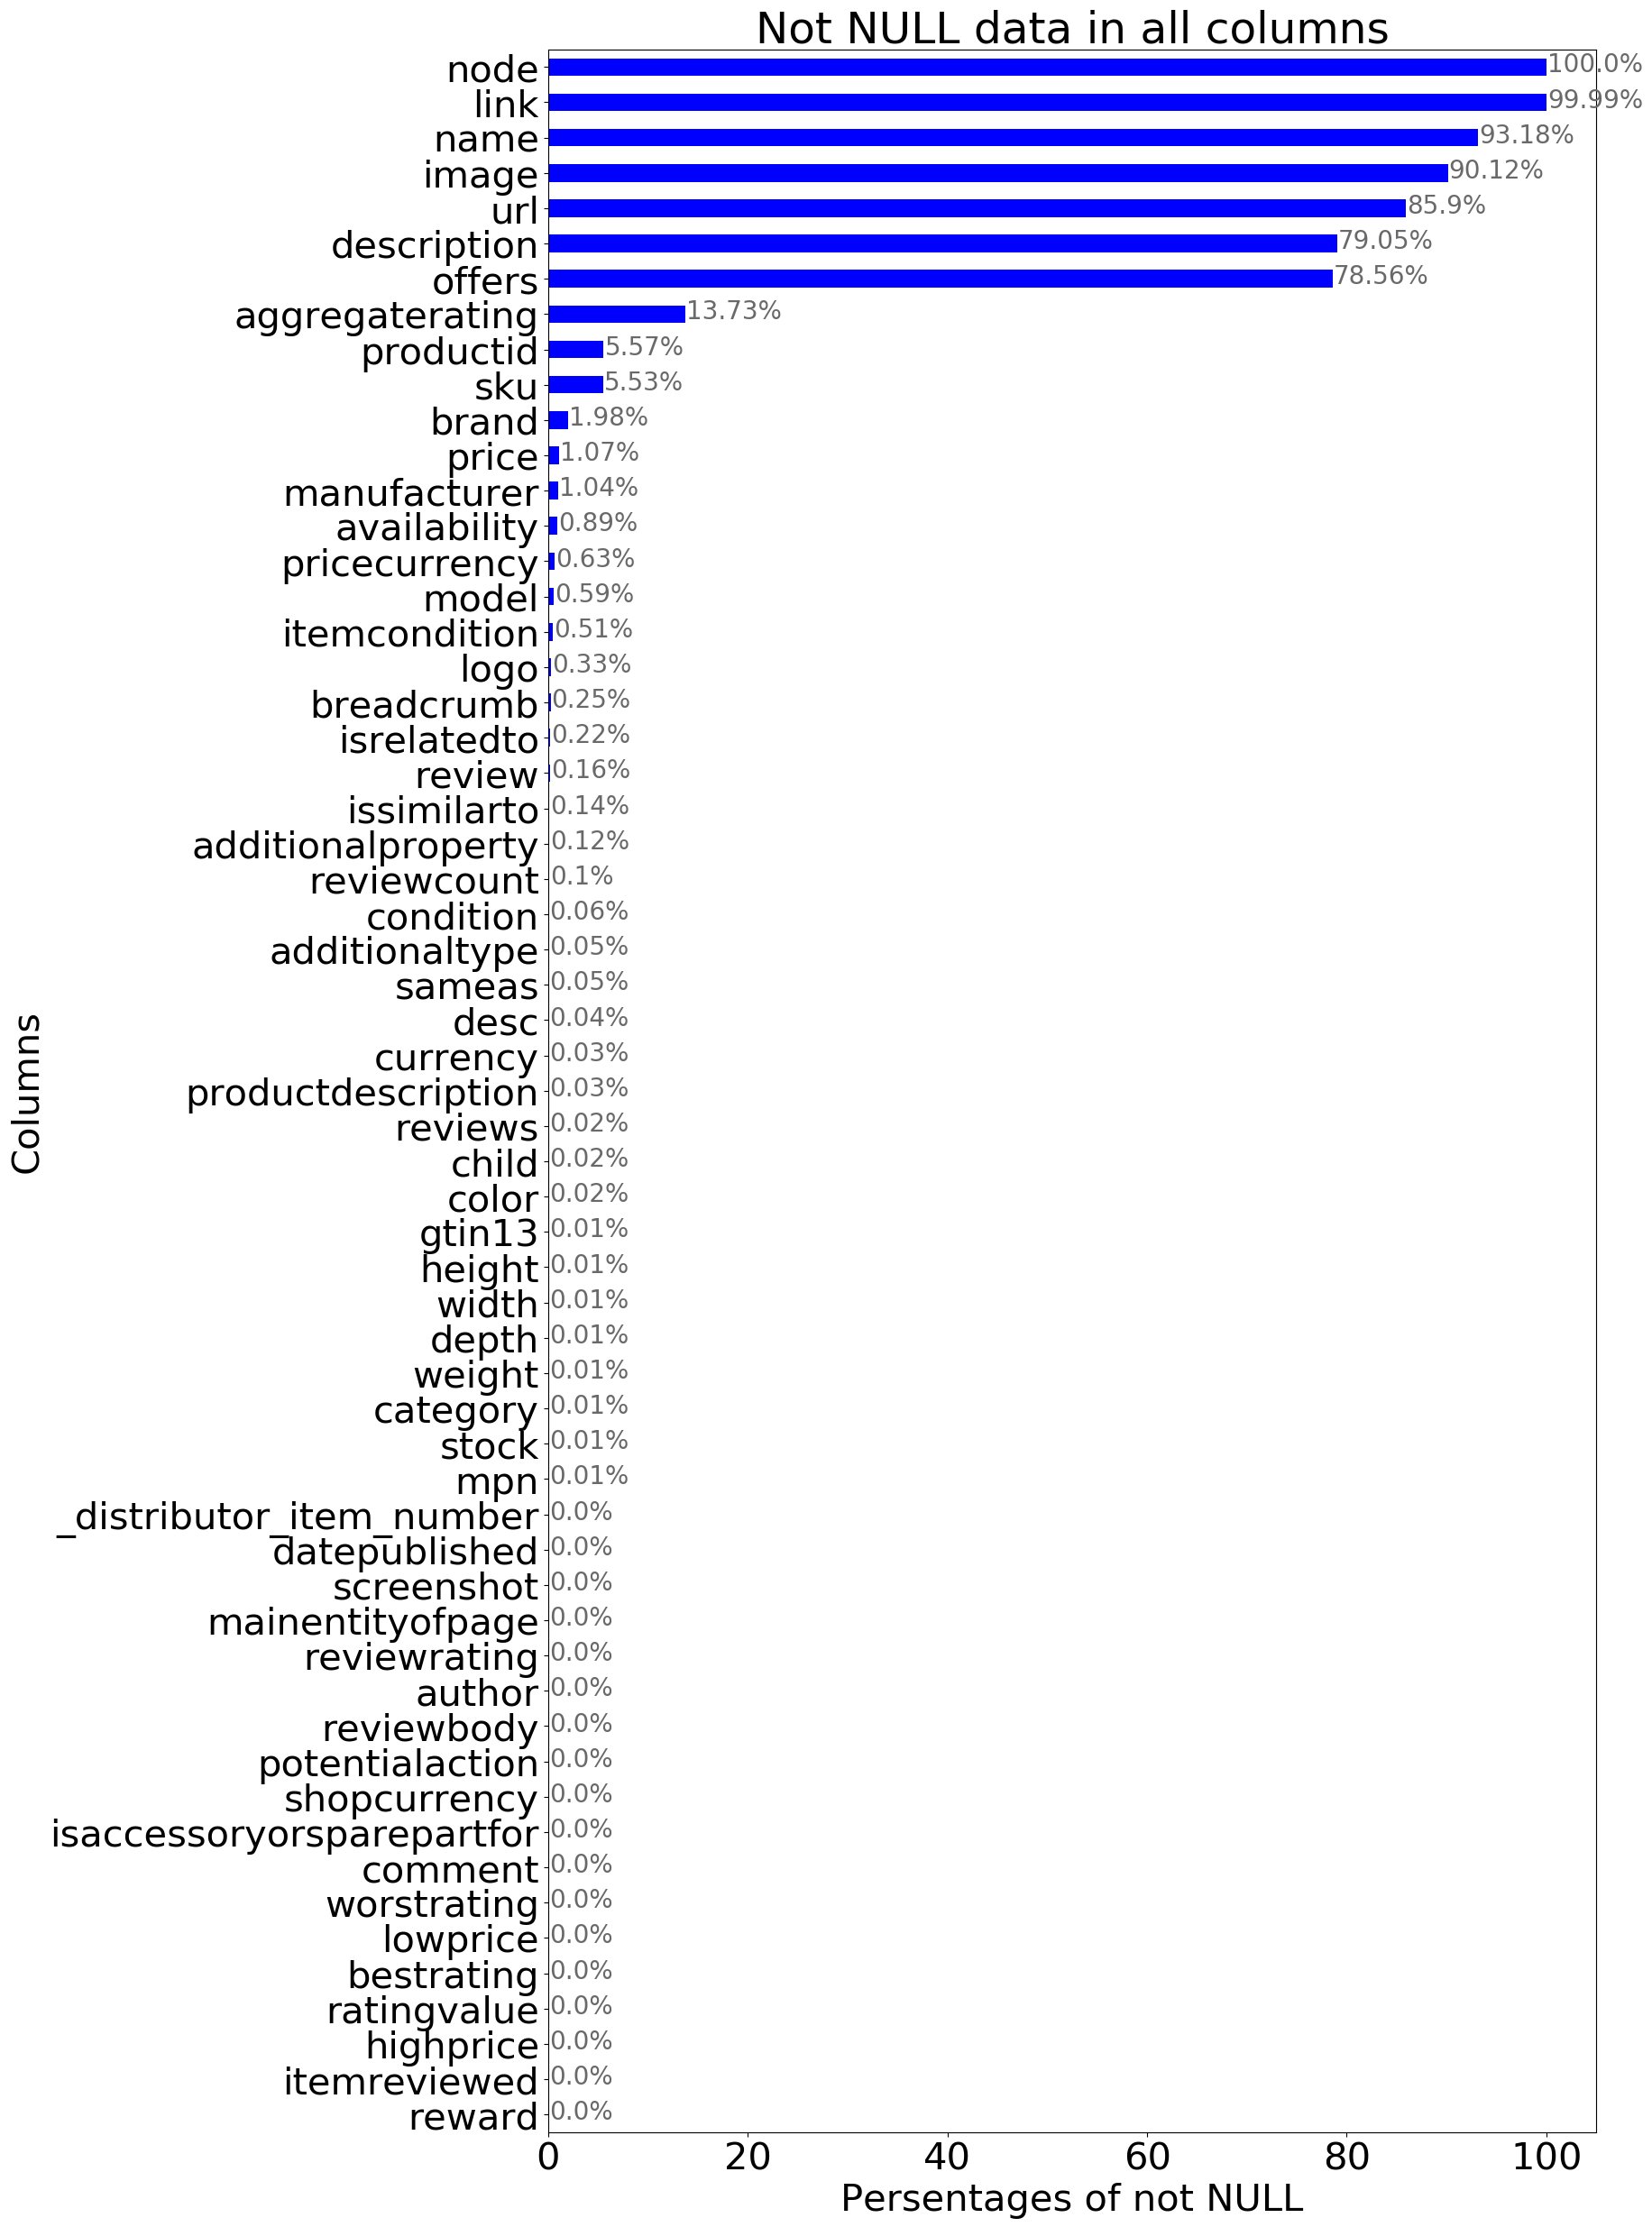

In [203]:
# Plot of not null data columns

import matplotlib.pyplot as plt
df = pd.DataFrame({'col':extracted_data.columns, 'col2':[float(float(len(extracted_data) - x)/len(extracted_data)*100) for x in extracted_data.isnull().sum()]})
df = df.sort_values("col2")
ax = df.plot(kind='barh', figsize=(15,30), color="blue", legend=False, fontsize=30);
ax.set_alpha(0.8)
ax.set_title("Not NULL data in all columns", fontsize=35)
ax.set_xlabel("Persentages of not NULL", fontsize=30)
ax.set_ylabel("Columns", fontsize=30)
ax.set_yticklabels(df.col)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.11, \
            str(round((i.get_width()), 2))+'%', fontsize=20, color='dimgrey')
plt.show()

### Analyse reasonable columns

In [44]:
# Explore reasonable data

reasonable_columns = []
for i in extracted_data.columns:
    if (float(float(len(extracted_data) - extracted_data[i].isnull().sum())/len(extracted_data)*100) >= 5):
        reasonable_columns.append(i)
        
explore_data = extracted_data[reasonable_columns]
explore_data.head()

,link,node,image,sku,aggregaterating,offers,description,productid,name,url
0,<https::www.paradiis.ee::/ru/22-tv-alused::nul...,node7a429218c67498c6039c111e9dddd3a,https://www.paradiis.ee/5654-home_default/mont...,NaN,NaN,node78ccb257509aa92b6ff1f5477483681c,Null,NaN,\u0422\u0443\u043C\u0431\u0430 \u0422\u0412 ...,https://www.paradiis.ee/ru/tv-alused/2371-mont...
1,<http::tamberi.eu::/73-ehtekaardid::null::2017...,node6883b5caa683772129c48f93ac5e99,http://tamberi.eu/707-home_default/ehtekaart.jpg,NaN,NaN,nodecae29666cd9b484fa96b027d8de4f42,Null,NaN,Ehtekaart,http://tamberi.eu/ehtekaardid/1780-ehtekaart.html
2,<http::mulgimoto.ee::/::product=eelsuute-relee...,node62d9afc3e4cd82a16e3f201ac4ea92,http://mulgimoto.ee/wp-content/uploads/2016/01...,"77910,ORIG.",NaN,node877954b546177da8bb3d93899df26c7,NaN,NaN,"EELS\u00DC\u00DCTE RELEE,YANMAR",http://mulgimoto.ee/?product=eelsuute-releeyanmar
3,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,https://nailin.ee/2012-home_default/akruulvarv...,NaN,NaN,nodea419737443083a78ebef53a54ec4ab,Akr\u00FC\u00FClv\u00E4rvid sisaldavad palju p...,NaN,"Akr\u00FC\u00FClv\u00E4rv, One Stroke, Phthalo...",https://nailin.ee/et/akruulvarvid/3201-akruulv...
4,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,http://www.kalastussport.ee/img/p/et-default-h...,NaN,NaN,nodeb03452c5604682994fea27bbf1835c8b,Null,NaN,Winter rod AKARA Legend,http://www.kalastussport.ee/taliridvad/466-win...


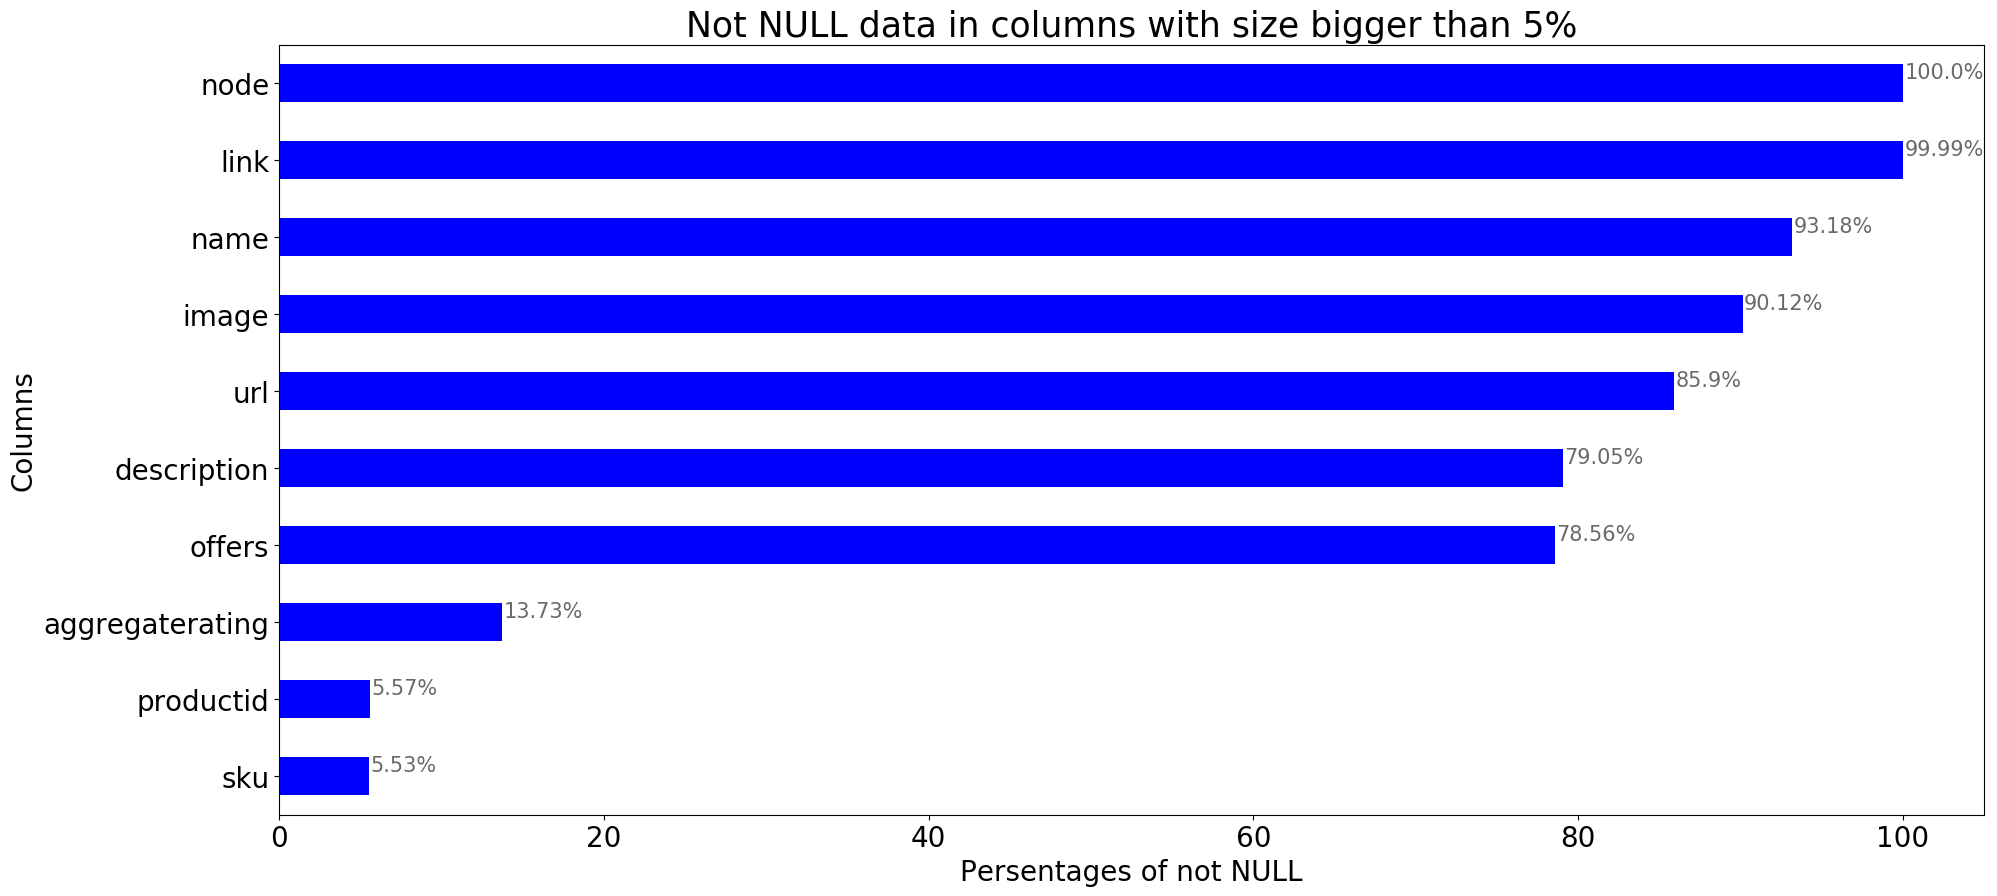

In [116]:
# Plot of not null data columns

df = pd.DataFrame({'col':explore_data.columns, 'col2':[float(float(len(explore_data) - x)/len(explore_data)*100) for x in explore_data.isnull().sum()]})
df = df.sort_values("col2")
ax = df.plot(kind='barh', figsize=(22,10), color="blue", legend=False, fontsize=20);
ax.set_alpha(0.8)
ax.set_title("Not NULL data in columns with size bigger than 5%", fontsize=25)
ax.set_xlabel("Persentages of not NULL", fontsize=20)
ax.set_ylabel("Columns", fontsize=20)
ax.set_yticklabels(df.col)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2))+'%', fontsize=15, color='dimgrey')
plt.show()

In [30]:
# Check content of those columns

# Link - only links

for i in explore_data['link']:
    if pd.notnull(i) and 'http' not in str(i):
        print(i)

In [31]:
# Node - only nodes

for i in explore_data['node']:
    if pd.notnull(i) and 'node' not in str(i):
        print(i)

In [42]:
# Image - only links

for i in explore_data['image']: 
    if pd.notnull(i) and 'http' not in str(i):
        print(i)

/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
//cdn.shopify.com/s/files/1/1520/4366/products/SATECHI_powerstrip_silver_1.jpg?v=1498175451
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.

Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816

Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
/media/img/thunderbird/thunderbird-256.e5af8f2b33f3.png
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Nu

Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
//static.netshop.ee/c/p/2015/04/49720TeF2af1.jpg
/media/img/thunderbird/thunderbird-256.e5af8f2b33f3.png
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
//static.netshop.ee/c/p/2016/12/68624TeF2916.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/thunderbird/thunderbird-256.e5af8f2b33f3.png
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
N

Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
/media/img/thunderbird/thunderbird-256.e5af8f2b33f3.png
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
N

/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
Null
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816.jpg
/media/img/firefox/firefox-256.e2c1fc556816

In [49]:
# sku - no useful text to analyse

for i in explore_data['sku']:
    if pd.notnull(i):
        print(i)

77910,ORIG.
EW027
1111655
EW160
EW106
EP193
CFMOTO650TR
T3016US
EP180
1111309
30500021
RY6SPORT50
3700917800072
Null
seg_fes1350
EW044Cane
EW025
ES054
ZZ09325
30500004
EC012
3760076652332
EW1011
EC114
T3007ES
one_inmotionv8
EC117
1161510
-
Null
3760076657108
-
34.15,B-OSA
EW093
ATV006S-7
EW030
ES104
HY...
-
1130221
ATV004S-7
Null
123
EW197
seg_icewheel
SQRACING80CCPUNANE
21.12,B-OSA
CFMOTO650NK
Null
T3017US
28304,B-OSA
T3021US
978-9949-9370-0-4
30-152
0248962
iSEO 5R
7317851138909
211-064
1038,B-OSA
28011
11903
Null
21-009
697045150205
0320484
11311,ORIG.
142-062
25-024
LI1609
TTTM-King
514
10001,B-OSA
172-042
G0128
212-041
Null
142
13157
016009
E300SGRAY
5124,B-OSA
G0091
G0145
311A3-1
EW025
1622klt
052-004
SKU999123
KK20840800
23.04
Null
071-045
U-ULTRA-B
345
211-007
051-004
SKU999123
143-001
051-004
LI1590
528
297
G0222
251-028
76472
296
4260199892046
one_ninebots2
28304,B-OSA
Null
178
141-099
Null
279
052-003
PG1572
7317852206973
0111211
H10-GL
G0181
252-041
252-046
13144
75019,B-OS

V12CRAB16S
7142
17234
LE-60-7\
SW5750CRAB_MM13
9005S5000
900744
mvp-neutron-inertia
4011
Null
PL-D1M3-02
PL-D24DY-18
BIO156
Allivio Len + turvah\u00E4ll
T3017US
8736
TTTM-King
n/a
mvp-eclipse-vector
Null
Null
BIO020
SW2034LTSMAB_F48
o.05149770000
A144
adCAP
H7Q4S5000
K5
Primus-P737937
Null
H3Q4S4300
0860A GRUPEE TROUSERS
71T2YE7 TS_OPORTO
Null
o.0410268.0000/1
Null
HennessyHex
FLESH00082
PA0204M
Tutek Timer Eco
axiom-proton-clash
Sawyer-Mini
adVW
n/a
HX6971/59
HB324V4300
SW2058CITAB_FS12
Null
023
Null
V12AMT_S20
mvp-eclipse-ion
HX8971/33
BIO020
17135
Null
SRM-LVF-5100A
001
Null
Null
Null
-
H1B018000
H7Q4S8000
mvp-neutron-shock
4204
Null
PL-D1A3-05
n/a
axiom-proton-crave
Null
Null
PA0204H
SW4428JT8M
o.0412732.0000/3
Null
4740
Null
WOCK-CLOG
o.0623938.0000
012
Null
ExplorerZIP
mvp-neutron-wave
mvp-eclipse-tangent
SW4428MRLD8MF
KCCHFA
SANDAAL - NURSE
Null
n/a
n/a
K4
Null
D2R5000
NS-828
Null
001
mvp-neutron-impulse
Null
Null
DD3x3
SW4428NDLT8MF
HX6064/07
123
o.0261971.0000
Null
Leatherman-

8001592000029
44 x 22 x 23 cm
A-CE410X
BSTAW20
1038133.00.70
BARUM-BRILLANTIS 2-165-65-13-77-L
1004
A95
XQ24293
vars + mopiraam + mopp 45cm
5778
pole saadaval
4,5 g
8437012435285
Tairi
BARUM-BRILLANTIS 2-175-65-14-82-K
UAG-IPH7/6S-M-GR
Continental-Premiumcontact 5-215-65-16-98-H
Null
SDC10G2/8GB
1611150205
40 x 29 x 12 cm
Null
BARUM-BRILLANTIS 2-155-80-13-79-T
Null
PV1703
5067
Null
                    N/A                   
BARUM-BRILLANTIS 2-165-70-14-81-P
SW1015
170110
89022
080326
vars 70 cm + hari 30 cm
1293,ORIG.
Continental-Premiumcontact 5-225-55-16-95-W
Null
104
                    N/A                   
-
2999
-
Null
9950
37971
HX10-S
PAKOP42075
Null
170011
P006
PGP2004
6178
MQF02
2058/600
Null
8716486000527
49351,ORIG.
Null
Null
1601200126
LTV-TV313
B001
UR1032811
Gloria
Null
02699,B-OSA
7804315304951
6588
Null
-
Null
UR1032809
008,0114
MS-42709
01500
VOOMBOX-B
19624
Null
MP2H2
1004
UDMA1
SDC10G2/16GB
SDCA3/32GB
8519
Null
R24-096717
Nordexx-Nivius Snow-175-70-13-T-82
JA-BOOST

Null
AWC - SANDAAL RIHMAGA
XQ23764
JA-ECLIPSE-W
A9S-G
266290210
Null
UAG-IPH7/6S-M-PL
SW2088CTAB16F
A027
AP310047
40 g
Null
6882-1603
SDCA3/64GB
DLX6038M
Nankang-SW-7-155-80-13-70-T
HR22110001
Continental-Premiumcontact 5-215-65-16-98-H
V\u00D5IMLEMISMATT - PRO
Null
SMK0026
                    4051268086738                   
4818
BARUM-BRILLANTIS 2-165-65-15-81-L
SDCA3/64GB
28304,B-OSA
JA-BOOST
U-11-128GB-DS-DB
S3TB
6.051,B-OSA
3760076653377
14415
Null
Continental-Premiumcontact 5-225-60-17-99-H
G0223
0337c91da1c9
4080
Null
Null
2035
Null
5 cm
9073
R1200695
Null
SDC10G2/8GB
25.03
A006
SDCA3/64GB
SMK0049
56368
p131011F
koolitus109
WW11137
712
5107,B-OSA
Null
17015
1601200102
4S464452
4770033228530
B032
1 tk
1608080109
Continental-Premiumcontact 5-205-60-16-92-H
090007
10990
\u04218612/065
WW11109
PAKOP37003
Y2285ARMOUTH 1B
75019,B-OSA
KR-60683
0512
1512090231
MQ192
Null
1707150113
EU05462
MPHJ2
PG1006
PGP1010
MS-447
B33
Null
p11250NE
A-F6U68AE
Null
SHRUNKEN TEE TRUE ICON
JA-SPORT-PACE-

W73L60 W7IY0
5255974-01
1448/S
T10-10SMD
861893
1448/S
UBE11417
Null
280321002/12
213851142/14
W73K68 W8SM0
T103A16
O1285DETTE 11R
334
7491
FL2HAD PAT07
6882-1603
HONEY FLAT CROSSOVER SOLID
1038420.09.70
JADA BALLARINA 1/2 SLV
W74K0L K6BP0
62G390 7982Z
TATE HEART HOODIE LS
Sena NST GD
D051BP
5019905.00.70
W64A46 D2C90
1692201
0586
Null
386
1781754
IMOGEN J6 BLAZER
FLJIL1 FAM12
K1285ESHA 7D
K575A16
HWVY66 89310
MATTHEW CHUNKY C-NK CF
SIA/PL951411
SADE CN SWEATER LS
W73R55 Z1L30
W41N05 W
DANIA LWK CN S/S
LEONA/PL502358
NALISE PLEATED DRESS SS
W53D07 W7HQ0
386
Null
1480/S
6072-2200
10990
JADA BALLERINA TOP 1/2 SLV
H1e
0860A GRUPEE TROUSERS
W73A27 W77R3
73P2YF0 PANT_LUCY
W64A35 D2C22
THDW BASIC CARDIGAN L/S 12
ECA623
420
W64D38 W7L00
W62I19 K0OY0
W61K22 W76A0@
2666
W0623L4
7493
6059-2200
4080
0016
53W501 5847Z
222-0021
Null
3922796.09.70
9660160-01
UBN21211
R24b
2792013
UBE51436
54W775 7829Z
LSQR22MTH
7491
ECR774
43W201 7334Z
PERI HWK LOGO PANT
BW4119 LEA35
Null
DAMIA WOVEN MM DRESS SS
FLR

LOU/PL951702
ADA PRINTED C-NK SWTR
Null
TH PREP BOXY CROSSOVER
RGBBLGL
R29
Ag925/Rh676700
306-312
pretty-love-butt-plug-massager
396
7491
1038195.09.71
TANK TOP APPL
RITA/PL230143
320
W63L10 W7IJ0
R7
8590004
LOGO 2 SCARF
D219SME
FL3VIR RUB10
W62L01 W7CH0
Elliot shawl sweater l/s
1036270.00.70
Null
Original stretch shirt l/s
R281l
TYKO-2 CN LWK L/S
707 6059 61041
3021241.09.70
Null
21015
Marlene
O54C12 MCR14
Null
HWVN67 79180
MR Skinny - Salted Blue
Birdy
IREN3 TOTE
B1285ERRY 16B
2700854
340
Lolly
2033671.00.70
HWPT64 22290
7503
RAVEN C-NK DRESS 1/2 SLV
STRAWBERRY/AL800030
CK REVERSIBLE BELT BOX
H1f
3821073.00.70
UBN21521
W73D57 D2NG0
1036270.00.70
1448/S
7502
ADIA REVERSIBLE DRESS
Null
420
W51R01 Z0DJ0
HWSS67 86180
MW3018L13
HWVY66 81290
UBE21203
Leanika
UBE71506
BW4119 LEA35
HWSS67 86180
D1632E
L1285AYLA 27A
SUSI3 LARGE TOTE
FL4ILS PEL12
Null
M1285ELLIE 8R
Mea
AN1351
W73043 D2N50
Marlene
Kylli
6.295-360
861584
861889
W62B01 K3PG0
THDW BIKER 25
HWLN64 22150
DW00100089
DW00100143
W62L09

513
8006102000179
SALSOLA65S-IN1.BI
6882-1603
8712231539632
K2013-575
K001
-
8717825660518
K6002-122
K2012-55
-
5060132280447
7105
-
-
K001N
8717825660617
Null
ET3
Null
-
K3003-94
8717825660532
K410
-
-
K1103-75
Null
-
NI_CJW6-M1-R8
-
Null
-
4038507004524
3112-5776
413
-
3329-6697
Null
00167
45x45.
K1024-5
N6 - FD
LC227BK/OK
008
SN_520134
-
4006040216216
Null
SN_734135
-
6138-1603
44973534/OK
00305
-
UDMB1
aedmustika vaarika mahemoos
8717825660662
v800
8716486000084
-
-
-
4740
K4
4606-4342
3538390000401
018
varre hoidja \u00FChele varrele
8717825668743
LC123Y/OK
-
1002011
-
040
UDMB1
-
001
4740504131249
CO_MA54-001
GS960inox
007
Tairi
STP 15x90 Haab A
116
444-S3PINK
4705A002/OK
NI_GT6-2PK-31
4748001002277
8716486000589
5060132280041
UDMB1
LC229XLBK/OK
74G402 8489Z
6720-1645
4011
-
5060132282052
5902480010270
00163
-
-
RR_97B
-
3800225477598
3272511010701
230722200007
8717825666190
K1031-65
V4130
-
K2004-6
ANNIA/PL952003
GS580inox
MC9600
2122
K2011-625
C7115A/OK
-
-
MG036
1002-85
MLT-D1

10990
Carolina
GRAN009
RC-E295-W
UR1032809
1 tk
UR1033202
SW87010WTH
HR22110111
JA-SPEAK-410
KR-60502
67537
978-9949-81-790-0
JA-SPORT-PACE-BL
UDMB1
350 m
AP310045
080326
WW11125
362
4S464452
PGP1062
16094
R964P17
RC-HI-RES-W
UAG-IPH7/6S-M-GR
XQ23764
59580
JA-SPORT-PACE-YL
UAG-IPH7/6S-M-GR
19624
JA-STEEL
V2976
376-153
HR54010911
MUJJO-SL-033-TN
750 ml
W64D50 Z1AJ0
HR57010211
00080436
1 L
10 pakki
LA5
500 ml
UAG-IPH7/6S-L-AS
58864
vars + p\u00F5randakaabits
UAG-IPH7/6SPLS-M-PL
KIARA PRT BRIEF
HR22110111
19623
ONGO-B
4579
57424-71270
IV-C100
XQ27730
PE400P
XQ23764
JA-HALO-FUSION
5 L
W73K77 K6120
69559
40 g
711
Lea
XQ24293
PE800P
JA-STEALTH
150 ml
KR-60503
50010
19623
ROME RW DEBRA
05-0138-00
4S464452
10 ml
SDCA3/32GB
72104\u00A0
0860A GRUPEE TROUSERS
HX6062/07
WH-31100BMLSSR
SGPH09CS20274
XQ24293
SDCA3/64GB
V91-029845
R805H16
XQ25798
JA-SPORT-PACE-BL
LVG222
0220875.00.10
JA-SPORT-PACE-RE
vars + mopp
707 1379 42131
Vars + mopiraam
N81
3333
JA-TOUR
75 ml
52 tk
PG5000
Null
17\
2033389.01.71

Continental-Premiumcontact 5-235-55-17-103-W
W53D07 W7HQ0
Null
LOUISA WINDBREAKER
Marlene
W72B79 K6EV0
63G827 8022Z
W72K89 W8GL0
SW87010WTH
THDW BASIC GRAPHIC CN HKNIT L/S 11
W34N05 K2CC0
PINCHO/PL900657
HERO HWK CN L/S
LIZ/PL952012
TAYLOR SOLID SKIRT
Nankang-SW-7-155-70-13-75-T
ROMINA/PL951717
5019283.00.70
W63L16 W7IL0
THDW HKNIT VARSITY JACKET L/S 17
010-01041-51
9f61408e3afb
Null
3021536.00.70
DALENE TENCEL SHIRT DRESS LS
Null
Continental-Premiumcontact 5-215-70-16-100-H
HENNY COTTON SWEATER
64G8028135Z
73P2YF0 PANT_LUCY
3921756.00.70
5513559.01.70
Null
Tracmax-Budget UHP-245-40-18-V-97
3022843.00.70
LAURIE/PL400974
THDW HD PARKA 8
W63R63 Z4Z00
Null
LIZ/PL952012
Continental-Premiumcontact 5-205-65-15-94-H
TB-BDC-CD-35
2932
TATE HEART HOODIE LS
6138-1603
W74Q53 K6930
JACKET GATINS
Jet Trucker - Waterfall
MG007
RITA/PL230143
HADAR CK LOGO CN LS
W63L19 W7IO0
THDW HKNIT VARSITY JACKET L/S 17
2103
R846A16
Hankook-RA18-205-65-16-107/105-T
IMOGEN J6 BLAZER
861909
Nankang-SW-7-165-80-13-83

Continental-Premiumcontact 5-225-65-17-102-V
2055
W63R80 Z1BR0
R23g
Continental-Premiumcontact 5-185-60-15-84-H
Continental-Premiumcontact 5-205-60-15-91-H
W53L50 W6RK0
3022843.00.70
331328
W72086 D2GK1
010-01534-16
Continental-Premiumcontact 5-195-55-16-87-H
R24c
5019904.00.70
3022662.00.75
Continental-Premiumcontact 5-215-55-16-93-H
Continental-Premiumcontact 5-185-60-15-84-H
Hankook-RA18-195-75-16-107/105-R
Barum-Sno Vanis 2-215-65-16-R-109/107
K575A16
71G732 8223Z
Null
THDW BASIC DOWN VEST 1
SAI HD CARDIGAN LS
CARMEN DB WOOL COAT
PL.15040XCYR/01
642e92efb794
Kylli
FEKLA DRESS NS
Null
Continental-Premiumcontact 5-195-55-15-85-H
W74K0L K6BP0
c74d97b01eae
3021536.00.70
NINA JUMPSUIT SS
Null
W63D48 W7P20
62G770 6299Z
c9f0f895fb98
JETRO_6702
BARUM-VANIS 2-185--14-102/100-P
W62D10 D1XA2
Continental-Premiumcontact 5-205-55-16-91-V
Inte tillg\u00E4nglig
21054
THDW BASIC DOWN COAT 3
VALENTINA DOWN VEST
861584
\u041D/\u0414
COLMA/PL951458
1038420.09.70
TAYLOR SOLID SKIRT
Continental-Premiumc

pretty-love-simon
NORDEXX-NU7000-225-65-17-102-L
390
Continental-Premiumcontact 5-205-60-16-92-H
n/a
Continental-Premiumcontact 5-195-60-15-88-H
Continental-Premiumcontact 5-205-60-16-92-H
2305
Continental-Premiumcontact 5-225-65-17-102-V
Null
Barum-Sno Vanis 2-185-80-14-Q-102/100
BARUM-BRILLANTIS 2-185-60-14-82-K
BARUM-BRAVURIS 3 HM-205-55-16-91-L
100
BARUM-BRAVURIS 3 HM-235-35-19-91-L
0155, 0038, 0179, 0152
2307721500009
tyre392157
Null
3700306987148
2234
350-0258
BARUM-BRAVURIS 3 HM-225-45-18-95-T
Null
358
BARUM-BRAVURIS 3 HM-205-55-16-91-L
Continental-Premiumcontact 5-165-70-14-81-T
BARUM-BRAVURIS 3 HM-215-50-17-91-R
Barum-SnoVanis 2-175-65-14-T-90/88
-
Continental-Premiumcontact 5-225-55-17-101-Y
BARUM-BRAVURIS 3 HM-225-55-18-98-K
BARUM-BRAVURIS 3 HM-195-50-15-82-L
BARUM-BRAVURIS 3 HM-225-50-16-92-K
Continental-Premiumcontact 5-195-60-15-88-H
BARUM-BRAVURIS 3 HM-225-45-18-95-T
BARUM-BRILLANTIS 2-145-70-13-71-T
BARUM-BRAVURIS 3 HM-255-40-20-101-K
MG119
2102
001
379
397-284
331-461


Continental-Premiumcontact 5-165-70-14-81-T
OR-DC-618
Continental-Premiumcontact 5-215-60-16-99-H
Continental-Premiumcontact 5-225-55-17-101-Y
BARUM-BRAVURIS 3 HM-255-45-20-101-N
BARUM-BRAVURIS 3 HM-235-50-19-99-T
BARUM-BRAVURIS 3 HM-255-40-19-100-T
BARUM-BRAVURIS 3 HM-205-50-16-87-T
K010
BARUM-BRAVURIS 3 HM-225-55-17-101-N
BARUM-BRAVURIS 3 HM-255-35-19-96-E
BARUM-BRAVURIS 3 HM-205-50-15-86-P
Continental-Premiumcontact 5-235-55-17-103-W
BARUM-BRAVURIS 3 HM-255-40-20-101-K
398
168
Null
10500
025
BARUM-BRAVURIS 3 HM-255-50
BARUM-BRAVURIS 3 HM-215-45-17-91-N
K1
BARUM-BRAVURIS 3 HM-195-50-16-88-E
Continental-Premiumcontact 5-185-65-15-88-T
lybaile-deluxe-waiter
THDM BASIC CN T-SHIRT S/S 17
Continental-Premiumcontact 5-205-60-16-92-H
BARUM-BRAVURIS 3 HM-225-55-17-101-N
8803/8820
BARUM-BRAVURIS 3 HM-205-40-17-84-P
4605/4602
BARUM-BRAVURIS 3 HM-255-45-18-103-R
978-9949-81-790-0
339
BARUM-BRAVURIS 3 HM-255-40-20-101-K
SMU0055
8717825663137
G0210
BARUM-BRAVURIS 3 HM-255-35-19-96-E
THDM WASHED P

pretty-love-brighty
BARUM-BRAVURIS 3 HM-255-35-20-97-K
119-551
Barum-SnoVanis 2-205-75-16-R-110/108
0103
2300
Nordexx-Nivius Snow-205-65-15-H-94
L580
BARUM-BRAVURIS 3 HM-245-45-18-96-N
693725
Null
BARUM-BRAVURIS 3 HM-255-45-20-101-N
12345
Null
089
NORDEXX-NU7000-265-65-17-112-E
BARUM-BRAVURIS 3 HM-225-50-17-98-L
K4
Continental-Premiumcontact 5-195-50-15-82-V
BARUM-BRAVURIS 3 HM-225-45-18-95-T
Continental-Premiumcontact 5-185-60-15-84-H
tyre392157
-
K6011
K007
BARUM-BRILLANTIS 2-155-65-13-73-R
Continental-Premiumcontact 5-225-65-17-102-V
K005
tyre392157
BARUM-BRAVURIS 3 HM-205-50-15-86-P
006
Continental-Premiumcontact 5-225-65-17-102-V
BARUM-BRAVURIS 3 HM-235-40-18-95-L
Continental-Premiumcontact 5-205-60-15-91-H
BARUM-BRAVURIS 3 HM-205-40-17-84-P
BARUM-BRAVURIS 3 HM-215-55-16-93-E
BARUM-BRAVURIS 3 HM-215-55-17-94-K
8717825668170
BARUM-BRILLANTIS 2-165-65-15-81-L
BARUM-BRILLANTIS 2-165-65-15-81-L
THDM BASIC CN T-SHIRT S/S 17
BARUM-BRAVURIS 3 HM-195-50-15-82-L
BARUM-BRAVURIS 3 HM-225-55-

In [51]:
# aggregaterating - only nodes

for i in explore_data['aggregaterating']:
    if pd.notnull(i) and 'node' not in i:
        print(i)

:


In [57]:
# offers - no useful text

offers_examples = []

for i in explore_data['offers']:
    if pd.notnull(i) and 'node' not in i:
        offers_examples.append(i)
        
len(offers_examples)

50

In [74]:
counter = 0
for i in offers_examples:
    if i not in [':nod',':no',':']:
        print(i)

                                      Aluminum Power Strip with 4 USB Charging Ports                                                                                                                                          $39.99                                                                                                                                                                                                                                                                                                                                  Silver - $39.99                                                                                                Gold - $39.99                                                                                                Space Gray - $39.99                                                                                                                                                            label[for=\product-select-option-0\] { display: none; }

In [10]:
# description - have useful text

descriptions = []
for i in explore_data['description']:
    if pd.notnull(i) and 'node' not in str(i) and str(i) != 'Null':
        descriptions.append(i)

descriptions[:20]

['Akr\\u00FC\\u00FClv\\u00E4rvid sisaldavad palju pigmenti, on v\\u00E4ga hea katvusega ning sobivad suurep\\u00E4raselt k\\u00FC\\u00FCnekaunistuste tegemiseks. V\\u00E4rvid on suure avaga klaastopsis, mist\\u00F5ttu neid neid on mugav kasutada.Akr\\u00FC\\u00FClv\\u00E4rve on k\\u00FC\\u00FCnele mugav kanda\\u00A0One Stroke pintslitega.',
 ' See esinduslik aiam\\u00F6\\u00F6bel on valmistatud romantilises ja ajatus lossipargi stiilis!',
 ' Alumiiniumtoru l\\u00E4bim\\u00F5\\u00F5t 3\\u00D73 /\\u00A02,5\\u00D72,5cm \\u00DClemised torud 1,2\\u00D72,2mm K\\u00FCljed 210g/m2 Kangas: Oxford PVC 420g/m2 V\\u00E4rv: sinine v\\u00F5i roheline',
 "Nutikas sensoriga armukuul, mida saad juhtida ap'istPersonaalne treening - lelu saab aru, kui tugevad on su lihased ning juhib treeningimpulsseN\\u00E4ed ise, kui tugevad on su seesmised lihased ja kuidas need arenevad6 treeningreziimih\\u00E4\\u00E4ljuhendamine",
 'Juhtmevaba pildiga vibraatormuna, millega omale kas sisemiselt v\\u00F5i v\\u00E4lis

In [134]:
# percentage of non empty text instances of description
float(float(len(descriptions))/len(explore_data))

0.5779611460666169

In [139]:
useful_descriptions = []
for i in descriptions:
    result = ''.join([j for j in i.strip('') if not j.isdigit()])
    if len(result) > 3:
        useful_descriptions.append(i)
        
float(float(len(useful_descriptions))/len(explore_data))

0.5442705556148022

In [159]:
useful_descriptions[:10]

['Akr\\u00FC\\u00FClv\\u00E4rvid sisaldavad palju pigmenti, on v\\u00E4ga hea katvusega ning sobivad suurep\\u00E4raselt k\\u00FC\\u00FCnekaunistuste tegemiseks. V\\u00E4rvid on suure avaga klaastopsis, mist\\u00F5ttu neid neid on mugav kasutada.Akr\\u00FC\\u00FClv\\u00E4rve on k\\u00FC\\u00FCnele mugav kanda\\u00A0One Stroke pintslitega.',
 ' See esinduslik aiam\\u00F6\\u00F6bel on valmistatud romantilises ja ajatus lossipargi stiilis!',
 ' Alumiiniumtoru l\\u00E4bim\\u00F5\\u00F5t 3\\u00D73 /\\u00A02,5\\u00D72,5cm \\u00DClemised torud 1,2\\u00D72,2mm K\\u00FCljed 210g/m2 Kangas: Oxford PVC 420g/m2 V\\u00E4rv: sinine v\\u00F5i roheline',
 "Nutikas sensoriga armukuul, mida saad juhtida ap'istPersonaalne treening - lelu saab aru, kui tugevad on su lihased ning juhib treeningimpulsseN\\u00E4ed ise, kui tugevad on su seesmised lihased ja kuidas need arenevad6 treeningreziimih\\u00E4\\u00E4ljuhendamine",
 'Juhtmevaba pildiga vibraatormuna, millega omale kas sisemiselt v\\u00F5i v\\u00E4lis

In [12]:
# productid - can have useful text, but size of useful instances is too small

productids = []

for i in explore_data['productid']:
    if pd.notnull(i) and 'node' not in str(i) and str(i) != 'Null' and not str(i).replace(' ', '').isdigit() and 'sku' not in str(i).lower():
        productids.append(i)
        
productids[:20]

['PA16822',
 'Bird Garden Duck Egg',
 'EXD18583',
 'Everglade Cherry',
 'Twig Apple',
 'Ferle Embroidery Tangerine Tangerine',
 'Imperio Steel',
 'Tootekood:SPA-F2',
 'Lana Cornflower',
 'Tootekood:WS112/S8',
 'AC18550*',
 'Seine Fabric Eau de Nil',
 'AC18570',
 'Renaissance Pebble',
 'AC18523',
 'PA16866',
 'AC18565',
 'Blazer Stripe Peony',
 'Hessian Ivory',
 'Firenze Ivory']

In [160]:
# percentage of non empty text instances of description
float(float(len(productids))/len(explore_data))

0.01795616935053855

In [13]:
useful_ids = []
for i in productids:
    result = ''.join([j for j in i.strip('') if not j.isdigit()])
    if len(result) > 3:
        useful_ids.append(i)
        
useful_ids[:10]

['Bird Garden Duck Egg',
 'Everglade Cherry',
 'Twig Apple',
 'Ferle Embroidery Tangerine Tangerine',
 'Imperio Steel',
 'Tootekood:SPA-F2',
 'Lana Cornflower',
 'Tootekood:WS112/S8',
 'Seine Fabric Eau de Nil',
 'Renaissance Pebble']

In [156]:
# percentage of non empty text instances of description
float(float(len(useful_ids))/len(explore_data))

0.014607994738900145

In [14]:
# name - useful text

names = []
for i in explore_data['name']:
    if pd.notnull(i) and 'node' not in str(i) and str(i) != 'Null':
        names.append(i)
        
# percentage of non empty text instances of description
float(float(len(names))/len(explore_data))

0.9312013437133412

In [130]:
names[:20]

['  \\u0422\\u0443\\u043C\\u0431\\u0430 \\u0422\\u0412 MontanaRTV',
 '  Ehtekaart',
 'EELS\\u00DC\\u00DCTE RELEE,YANMAR',
 'Akr\\u00FC\\u00FClv\\u00E4rv, One Stroke, Phthalo Green, 15ml',
 'Winter rod AKARA Legend',
 '  PEARL AIAM\\u00D6\\u00D6BEL',
 '  Digital pressure sensor BMP280',
 '  HOPP POROLOONMADRATS',
 '  Analog-digital converter 16-bit ADS1115',
 '  LUNA MADRATS',
 '  Pop-Up telk 3x4,5m',
 'Nuti-armukuul Gballs 2 roosa',
 'Vibratsiooniga armukuul Shiver S sinine',
 '  Power Charger 5V/2.5A',
 'Zebra poolkuu 100 grit',
 '  K\\u00F5rvar\\u00F5ngad',
 'Braun Series 9 9290cc Wet&Dry Foil shaver...',
 '\\u0425\\u0430\\u043A\\u043A\\u0438 \\u043A\\u0443\\u0440\\u0442\\u043A\\u0430',
 '  CATRINE DIIVANVOODI',
 '  pisi-XBee 5 ATxmega32A4U board']

In [15]:
useful_names = []
for i in names:
    result = ''.join([j for j in i.strip('') if not j.isdigit()])
    if len(result) > 3:
        useful_names.append(i)
        
useful_names[:10]

['  \\u0422\\u0443\\u043C\\u0431\\u0430 \\u0422\\u0412 MontanaRTV',
 '  Ehtekaart',
 'EELS\\u00DC\\u00DCTE RELEE,YANMAR',
 'Akr\\u00FC\\u00FClv\\u00E4rv, One Stroke, Phthalo Green, 15ml',
 'Winter rod AKARA Legend',
 '  PEARL AIAM\\u00D6\\u00D6BEL',
 '  Digital pressure sensor BMP280',
 '  HOPP POROLOONMADRATS',
 '  Analog-digital converter 16-bit ADS1115',
 '  LUNA MADRATS']

In [163]:
# percentage of non empty text instances of description
float(float(len(useful_names))/len(explore_data))

0.9287574206391526

In [117]:
# url - no useful text

for i in explore_data['url']:
    if pd.notnull(i) and 'node' not in str(i) and str(i) != 'Null' and 'http' not in str(i) and str(i) not in ['htt','h']:
        print(i)

 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi..

/toode/eisma-24-28-juuli-1000-1200/
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
/toode/eisma-24-28-juuli-1300-1500/
 Vaata edasi...
 Vaata Rohkem...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
/toode/voistluslitsents/
 Vaata Rohkem...
/toode/eesti-purjetamise-kongressile-registreerumine/
 Vaata edasi...
 Vaata Rohkem...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata edasi...
 Vaata

 Vaata edasi...
 Vaata Rohkem...
 Vaata edasi...
 Vaata edasi...
 Vaata edasi...
 Vaata Rohkem...
 Vaata Rohkem...


### Analyse useful text columns

In [204]:
useful_col = ['link', 'node', 'description', 'productid', 'name']
useful_data = explore_data[useful_col]
useful_data.head()

,link,node,description,productid,name
0,<https::www.paradiis.ee::/ru/22-tv-alused::nul...,node7a429218c67498c6039c111e9dddd3a,Null,NaN,\u0422\u0443\u043C\u0431\u0430 \u0422\u0412 ...
1,<http::tamberi.eu::/73-ehtekaardid::null::2017...,node6883b5caa683772129c48f93ac5e99,Null,NaN,Ehtekaart
2,<http::mulgimoto.ee::/::product=eelsuute-relee...,node62d9afc3e4cd82a16e3f201ac4ea92,NaN,NaN,"EELS\u00DC\u00DCTE RELEE,YANMAR"
3,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,Akr\u00FC\u00FClv\u00E4rvid sisaldavad palju p...,NaN,"Akr\u00FC\u00FClv\u00E4rv, One Stroke, Phthalo..."
4,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,Null,NaN,Winter rod AKARA Legend


#### Description column

In [125]:
float(float(len(extracted_data['description']) - extracted_data['description'].isnull().sum())/len(extracted_data['description'])*100)

79.06180014930149

In [2]:
# Apply language separation

useful_data['Langs'] = useful_data.apply(lambda row: language_detection_with_sent(row['description']), axis=1)

NameError: name 'useful_data' is not defined

In [103]:
def parse_data (array, counter):
    if str(array) != 'None':
        return str(array[counter])
    else:
        return
    
def new_columns (df, string):
    new_cols = ['Lang1_', 'Lang2_', 'Lang3_', 'Prob1_', 'Prob2_', 'Prob3_', 'Text1_', 'Text2_', 'Text3_']
    counter = 0
    for i in new_cols:
        df[i+string] = df.apply(lambda row: parse_data(row['Langs'], counter), axis = 1)
        counter += 1 

In [156]:
# Len of instances

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
all_len = []
for i in useful_names:
    words = tokenizer.tokenize(str(i))
    all_len.append(len(words))
    
print(float(sum(all_len))/float(len(all_len)))

6.16589000789


In [73]:
new_columns(useful_data, 'description')
useful_data.drop('Langs', inplace = True, axis = 1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [1]:
# Language hist

count = useful_data['Lang1_description'].value_counts().to_dict()
df = pd.DataFrame({'col':count.keys(), 'col2':count.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "Lang1_description", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

NameError: name 'useful_data' is not defined

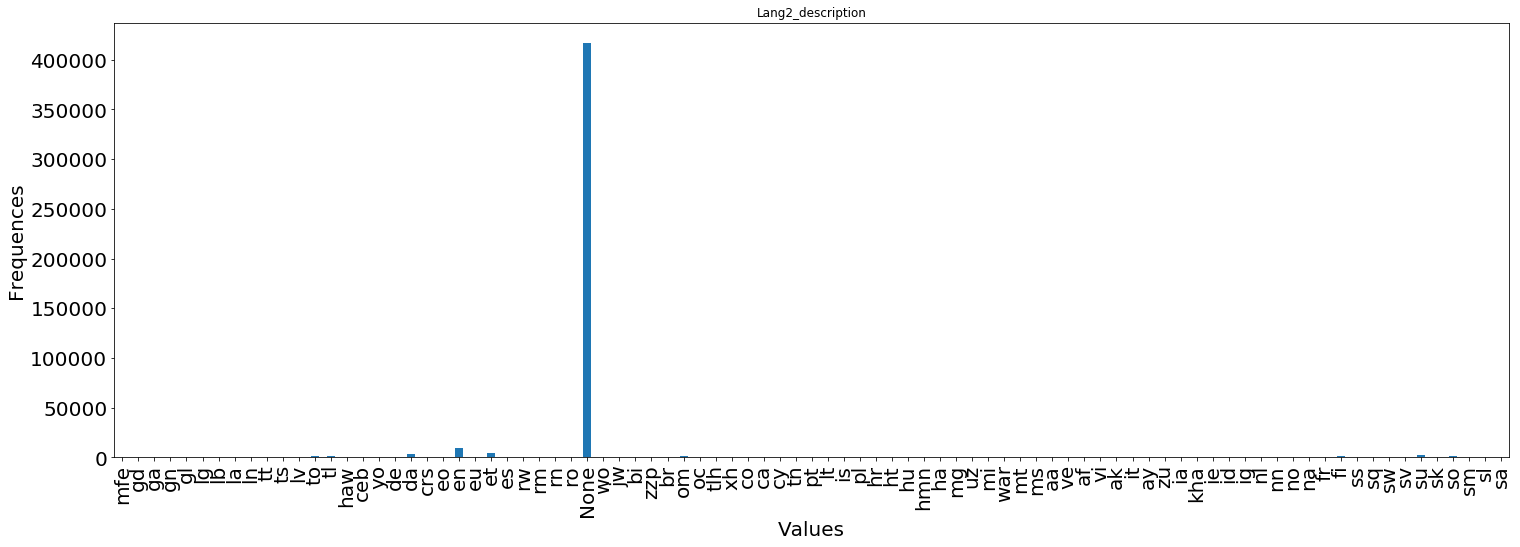

In [98]:
count = useful_data['Lang2_description'].value_counts().to_dict()
df = pd.DataFrame({'col':count.keys(), 'col2':count.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "Lang2_description", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

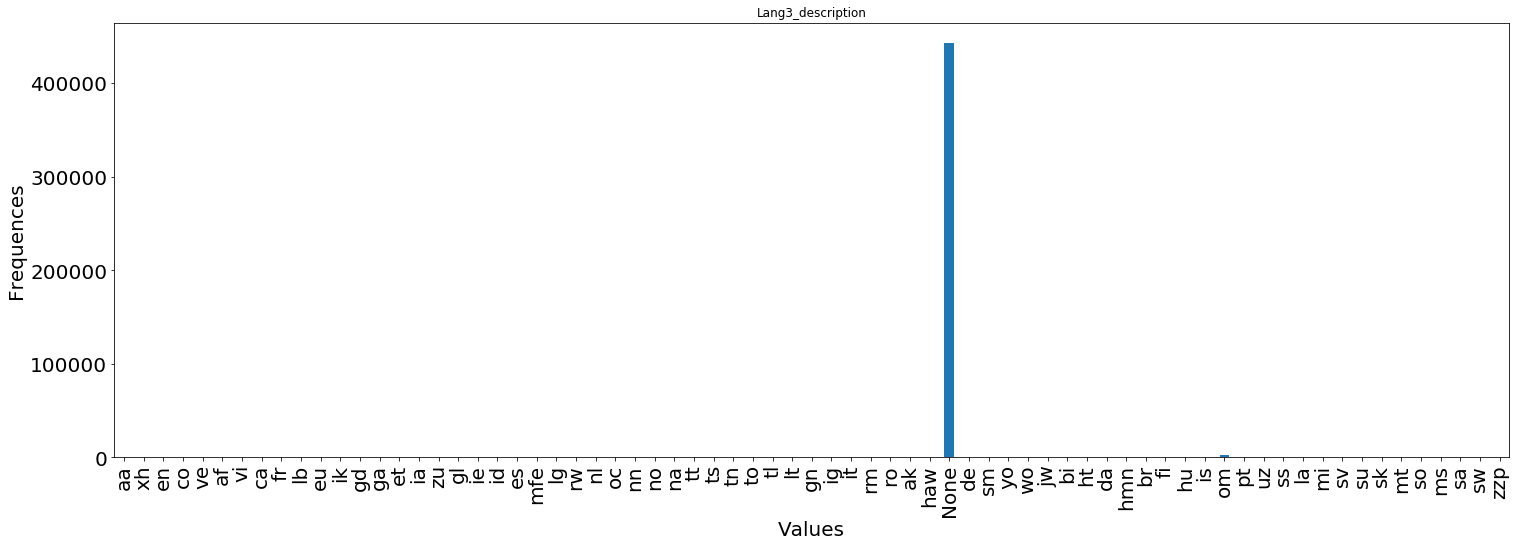

In [99]:
count = useful_data['Lang3_description'].value_counts().to_dict()
df = pd.DataFrame({'col':count.keys(), 'col2':count.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "Lang3_description", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

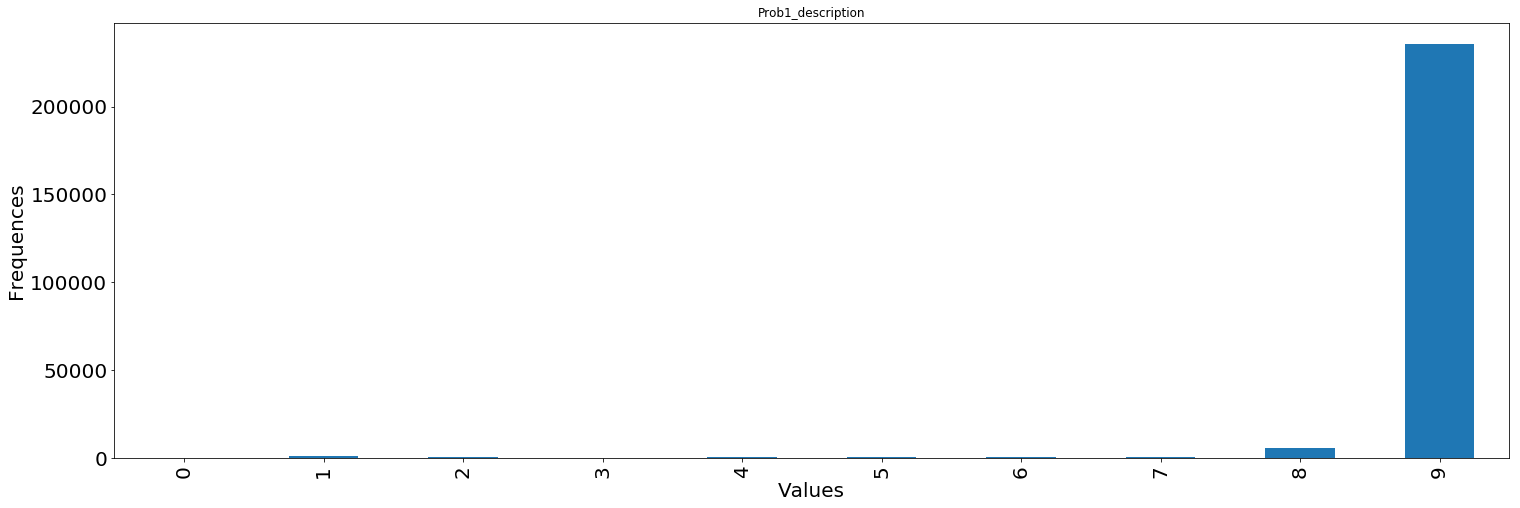

In [184]:
# Probability hist

count = {}
for i in range(10): 
    count[i] = 0

for i in useful_data['Prob1_description']:
    if str(i) != 'None':
        key = int(float(i)*10)
        count[key] += 1

df = pd.DataFrame({'col':count.keys(), 'col2':count.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "Prob1_description", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

#### Name column

In [126]:
float(float(len(extracted_data['name']) - extracted_data['name'].isnull().sum())/len(extracted_data['name'])*100)

93.18367637126302

In [102]:
# Apply language separation

useful_data['Langs'] = useful_data.apply(lambda row: language_detection_with_sent(row['name']), axis=1)

In [105]:
new_columns(useful_data, 'name')
useful_data.drop('Langs', inplace = True, axis = 1)

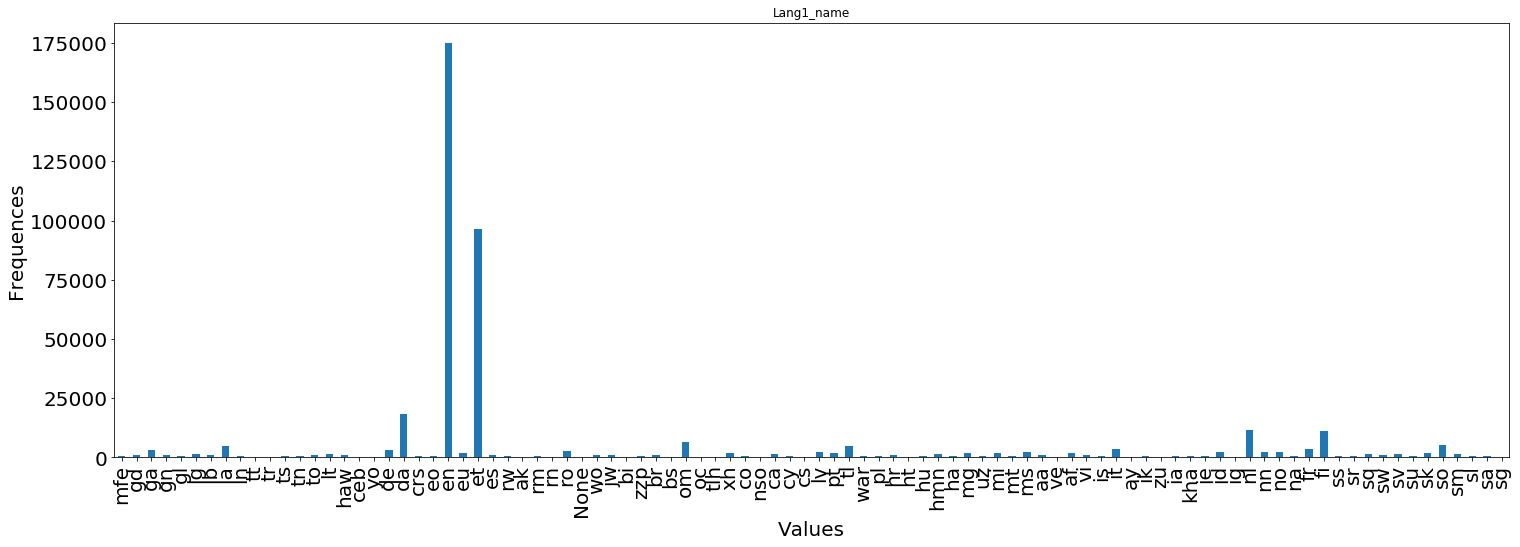

In [107]:
# Language hist

count = useful_data['Lang1_name'].value_counts().to_dict()
df = pd.DataFrame({'col':count.keys(), 'col2':count.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "Lang1_name", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

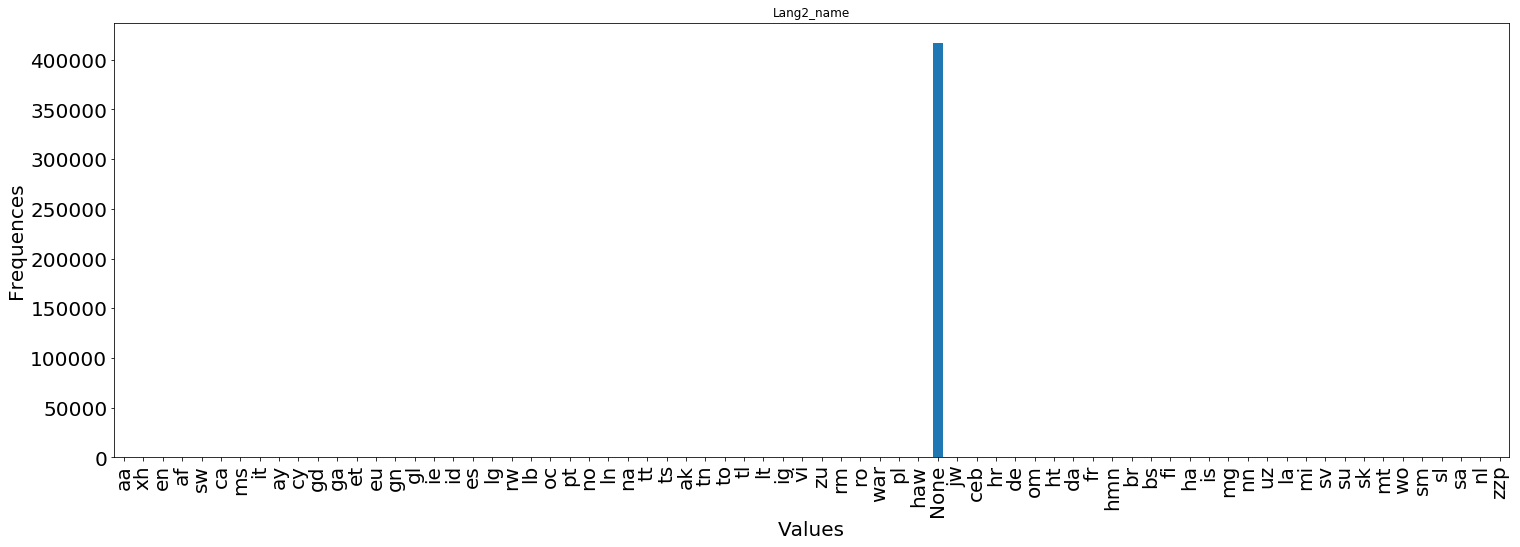

In [108]:
count = useful_data['Lang2_name'].value_counts().to_dict()
df = pd.DataFrame({'col':count.keys(), 'col2':count.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "Lang2_name", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

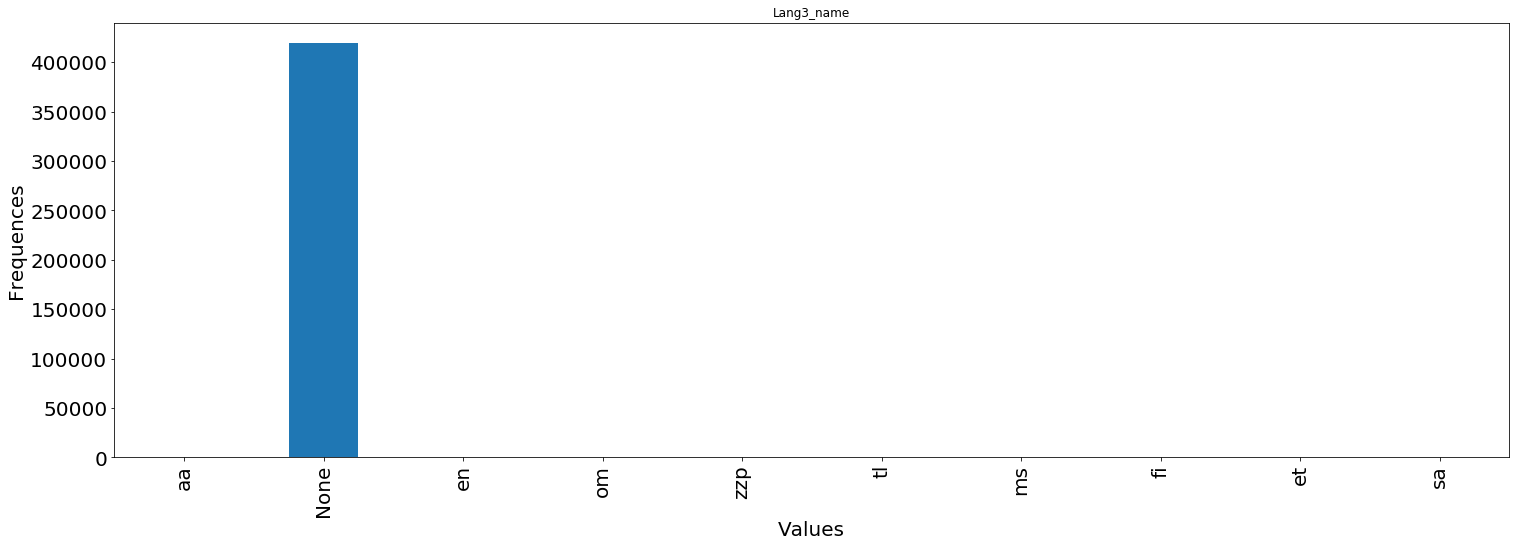

In [109]:
count = useful_data['Lang3_name'].value_counts().to_dict()
df = pd.DataFrame({'col':count.keys(), 'col2':count.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "Lang3_name", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

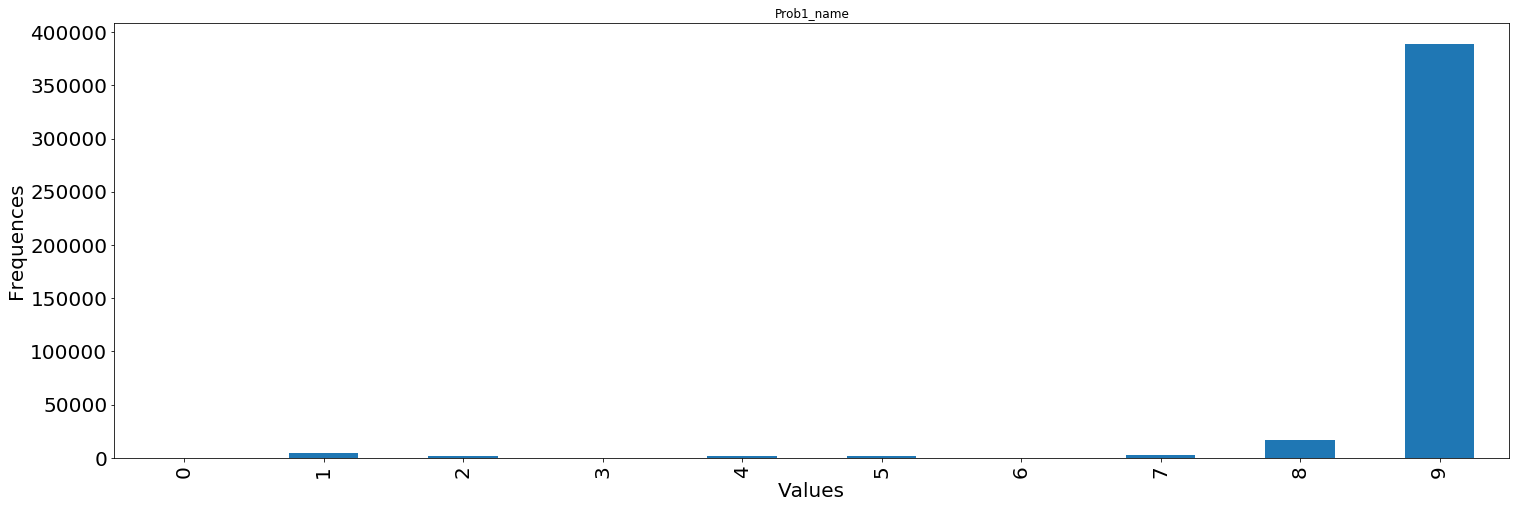

In [183]:
# Probability hist

count = {}
for i in range(10): 
    count[i] = 0

for i in useful_data['Prob1_name']:
    if str(i) != 'None':
        key = int(float(i)*10)
        count[key] += 1

df = pd.DataFrame({'col':count.keys(), 'col2':count.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "Prob1_name", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

#### Productid column

In [111]:
# Apply language separation

useful_data['Langs'] = useful_data.apply(lambda row: language_detection_with_sent(row['productid']), axis=1)

In [113]:
new_columns(useful_data, 'productid')
useful_data.drop('Langs', inplace = True, axis = 1)

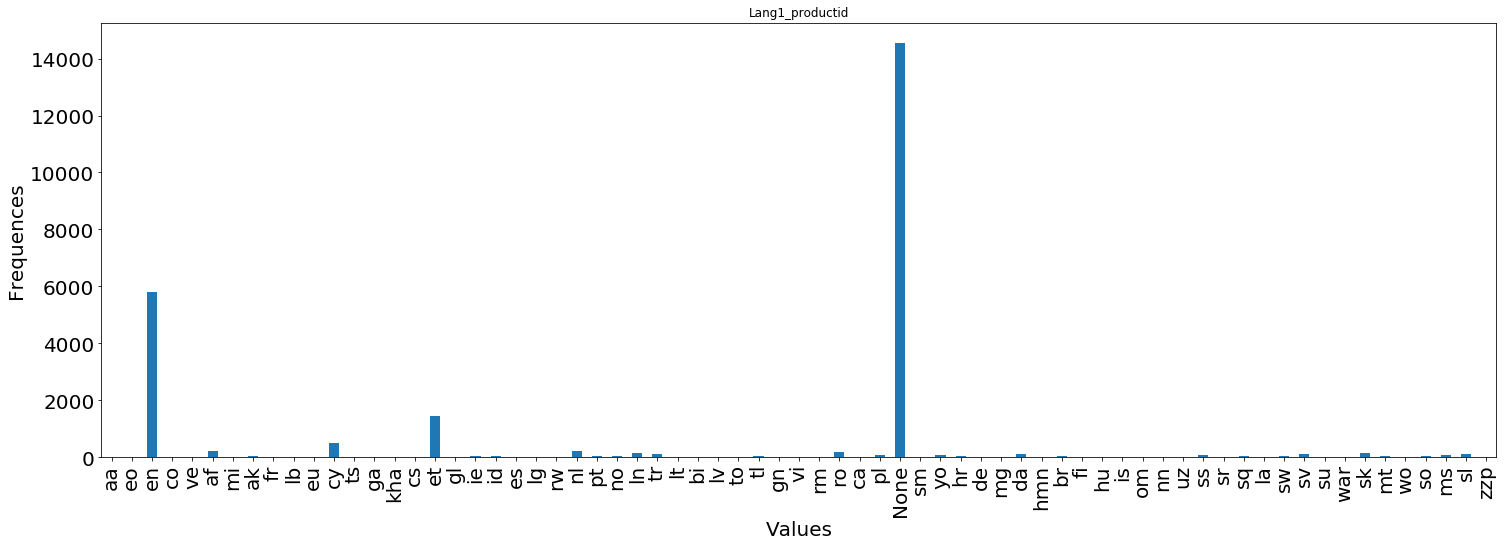

In [115]:
# language hist

#Lang 2 and Lang 3 have only Nones

count = useful_data['Lang1_productid'].value_counts().to_dict()
df = pd.DataFrame({'col':count.keys(), 'col2':count.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "Lang1_productid", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

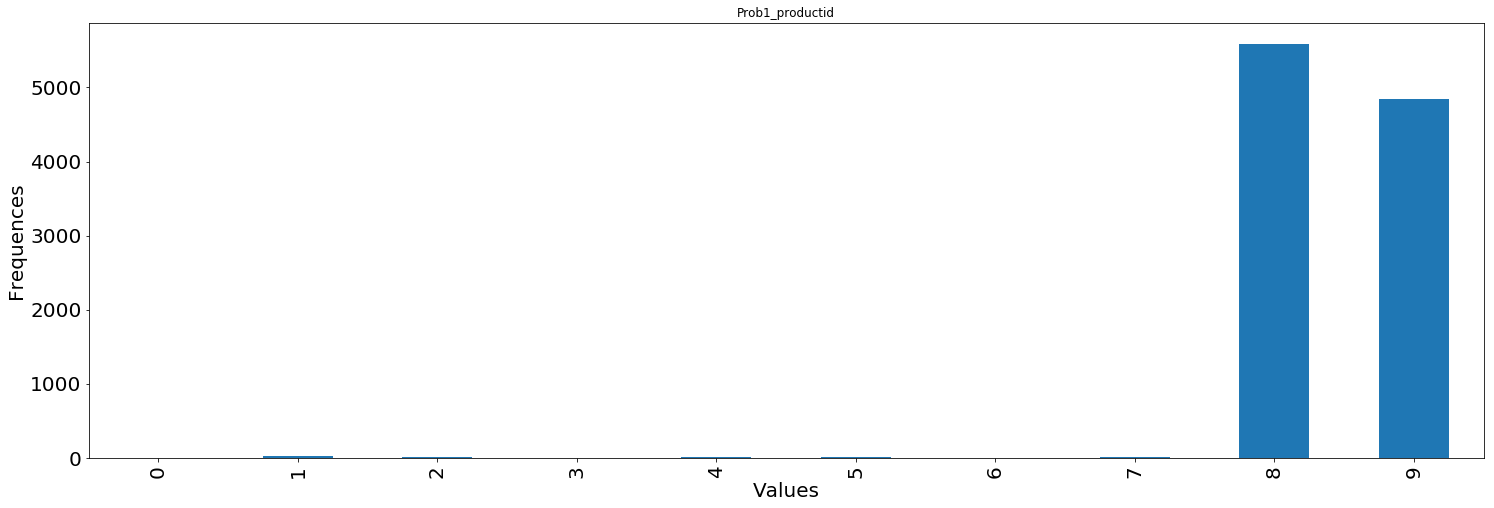

In [182]:
# Probability hist

count = {}
for i in range(10): 
    count[i] = 0

for i in useful_data['Prob1_productid']:
    if str(i) != 'None':
        key = int(float(i)*10)
        count[key] += 1

df = pd.DataFrame({'col':count.keys(), 'col2':count.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "Prob1_productid", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

#### Cut useless columns

In [160]:
# description

useful_data.drop('Lang2_description', inplace = True, axis = 1)
useful_data.drop('Lang3_description', inplace = True, axis = 1)
useful_data.drop('Prob2_description', inplace = True, axis = 1)
useful_data.drop('Prob3_description', inplace = True, axis = 1)
useful_data.drop('Text2_description', inplace = True, axis = 1)
useful_data.drop('Text3_description', inplace = True, axis = 1)

In [119]:
# productid

useful_data.drop('Lang2_productid', inplace = True, axis = 1)
useful_data.drop('Lang3_productid', inplace = True, axis = 1)
useful_data.drop('Prob2_productid', inplace = True, axis = 1)
useful_data.drop('Prob3_productid', inplace = True, axis = 1)
useful_data.drop('Text2_productid', inplace = True, axis = 1)
useful_data.drop('Text3_productid', inplace = True, axis = 1)

In [161]:
# name

useful_data.drop('Lang2_name', inplace = True, axis = 1)
useful_data.drop('Lang3_name', inplace = True, axis = 1)
useful_data.drop('Prob2_name', inplace = True, axis = 1)
useful_data.drop('Prob3_name', inplace = True, axis = 1)
useful_data.drop('Text2_name', inplace = True, axis = 1)
useful_data.drop('Text3_name', inplace = True, axis = 1)

#### Join useful text together

In [219]:
def join_by_lang(row):
    text = ''
    lang = ''
    d = 0
    n = 0
    p = 0
    if row['Lang1_description'] == row['Lang1_name'] and row['Prob1_description'] > 0.5 and row['Prob1_name'] > 0.5:
        lang = row['Lang1_description']
        if d == 0:
            text += row['Text1_description']
            d = 1
        if n == 0:
            text += row['Text1_name']
            n = 1
    if row['Lang1_productid'] == row['Lang1_name'] and row['Prob1_productid'] > 0.5 and row['Prob1_name'] > 0.5:
        lang = row['Lang1_name']
        if p == 0:
            text += row['Text1_productid']
            p = 1
        if n == 0:
            text += row['Text1_name']
            n = 1
    if row['Lang1_description'] == row['Lang1_productid'] and row['Prob1_description'] > 0.5 and row['Prob1_productid'] > 0.5:
        lang = row['Lang1_description']
        if d == 0:
            text += row['Text1_description']
            d = 1
        if p == 0:
            text += row['Text1_productid']
            p = 1
    if text == '':
        all_cols = ['description', 'name', 'productid']
        for i in all_cols:
            if row['Lang1_'+i] in ['en', 'et'] and row['Prob1_'+i] > 0.5:
                lang = row['Lang1_'+i]
                text = row['Text1_'+i]
    return (lang, text)

In [233]:
useful_data['tmp'] = useful_data.apply(lambda x: join_by_lang(x), axis = 1)
useful_data['lang_join'] = useful_data.apply(lambda x: x['tmp'][0], axis = 1)
useful_data['text_join'] = useful_data.apply(lambda x: x['tmp'][1], axis = 1)
useful_data = useful_data.drop(['tmp'], axis = 1)
useful_data['lang_join'] = useful_data['lang_join'].replace('', 'None')
useful_data['text_join'] = useful_data['text_join'].replace('', 'None')

In [232]:
#useful_data = useful_data.drop(['lang_join'], axis = 1)
#useful_data = useful_data.drop(['text_join'], axis = 1)

In [238]:
useful_data.head(20)

,link,node,description,productid,name,Lang1_description,Prob1_description,Text1_description,Lang1_name,Prob1_name,Text1_name,Lang1_productid,Prob1_productid,Text1_productid,lang_join,text_join
0,<https::www.paradiis.ee::/ru/22-tv-alused::nul...,node7a429218c67498c6039c111e9dddd3a,Null,NaN,\u0422\u0443\u043C\u0431\u0430 \u0422\u0412 ...,None,None,None,om,0.95,uuuCuu uu MontanaRTV,None,None,None,None,None
1,<http::tamberi.eu::/73-ehtekaardid::null::2017...,node6883b5caa683772129c48f93ac5e99,Null,NaN,Ehtekaart,None,None,None,et,0.9,Ehtekaart,None,None,None,et,Ehtekaart
2,<http::mulgimoto.ee::/::product=eelsuute-relee...,node62d9afc3e4cd82a16e3f201ac4ea92,NaN,NaN,"EELS\u00DC\u00DCTE RELEE,YANMAR",None,None,None,zzp,0.96,EELSuDCuDCTE RELEEYANMAR,None,None,None,None,None
3,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,Akr\u00FC\u00FClv\u00E4rvid sisaldavad palju p...,NaN,"Akr\u00FC\u00FClv\u00E4rv, One Stroke, Phthalo...",et,0.99,AkruFCuFClvuErvid sisaldavad palju pigmenti on...,en,0.97,AkruFCuFClvuErv One Stroke Phthalo Green ml,None,None,None,en,AkruFCuFClvuErv One Stroke Phthalo Green ml
4,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,Null,NaN,Winter rod AKARA Legend,None,None,None,en,0.96,Winter rod AKARA Legend,None,None,None,en,Winter rod AKARA Legend
5,<https::www.paradiis.ee::/et/128-kampaania::p=...,noded2b1c726cca5417aadf2c82e333d51b6,See esinduslik aiam\u00F6\u00F6bel on valmist...,NaN,PEARL AIAM\u00D6\u00D6BEL,et,0.98,See esinduslik aiamuFuFbel on valmistatud rom...,gd,0.94,PEARL AIAMuDuDBEL,None,None,None,et,See esinduslik aiamuFuFbel on valmistatud rom...
6,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449,Null,NaN,Digital pressure sensor BMP280,None,None,None,en,0.96,Digital pressure sensor BMP,None,None,None,en,Digital pressure sensor BMP
7,<https::www.paradiis.ee::/et/8-lastetuba::p=2:...,nodea018523cd7c8d8dea81c8af4d6a85e7,Null,NaN,HOPP POROLOONMADRATS,None,None,None,no,0.95,HOPP POROLOONMADRATS,None,None,None,None,None
8,<http::www.ittgroup.ee::/en/31-converters::nul...,node67109f1f1de73f41d2979d4561221,Null,NaN,Analog-digital converter 16-bit ADS1115,None,None,None,en,0.96,Analogdigital converter bit ADS,None,None,None,en,Analogdigital converter bit ADS
9,<https::www.paradiis.ee::/et/15-madratsid::nul...,nodeead56cd28c8c78392c73a3265f9aa086,Null,NaN,LUNA MADRATS,None,None,None,haw,0.92,LUNA MADRATS,None,None,None,None,None


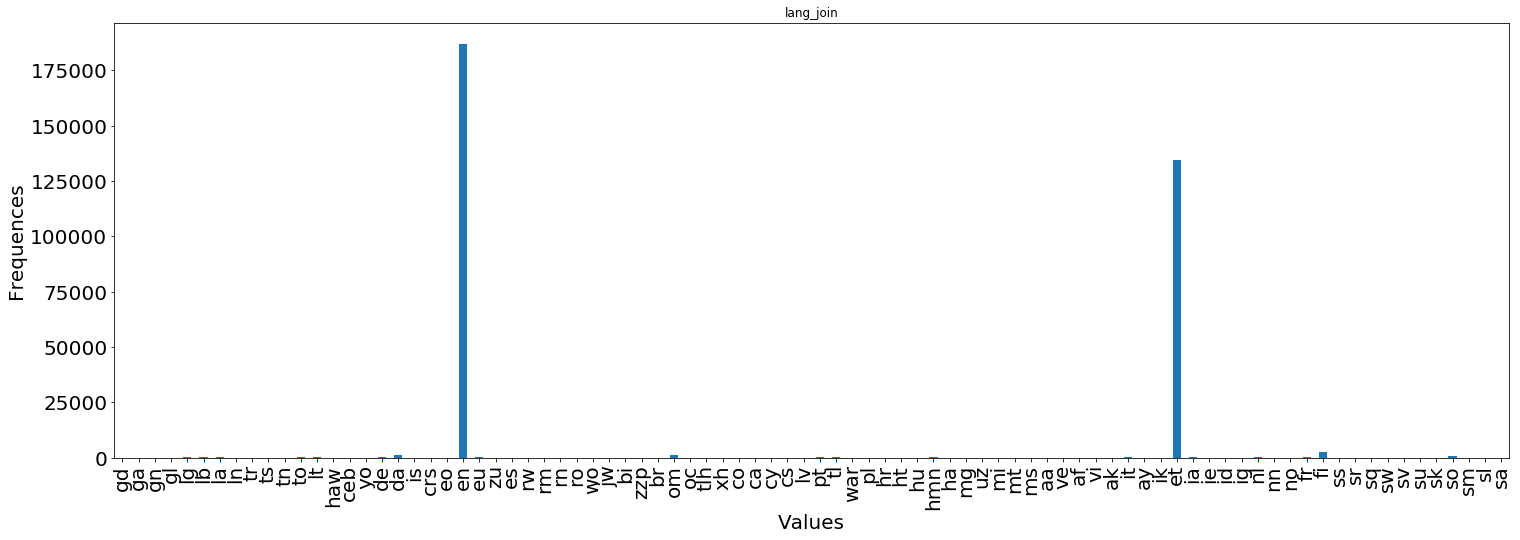

In [271]:
# language hist

count = useful_data['lang_join'].value_counts().to_dict()
del count['None']
df = pd.DataFrame({'col':count.keys(), 'col2':count.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "lang_join", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

In [270]:
float(float(len(useful_data['lang_join']) - len(useful_data['lang_join'][useful_data['lang_join'] == 'None']))/len(useful_data['lang_join'])*100)

73.66428495254345

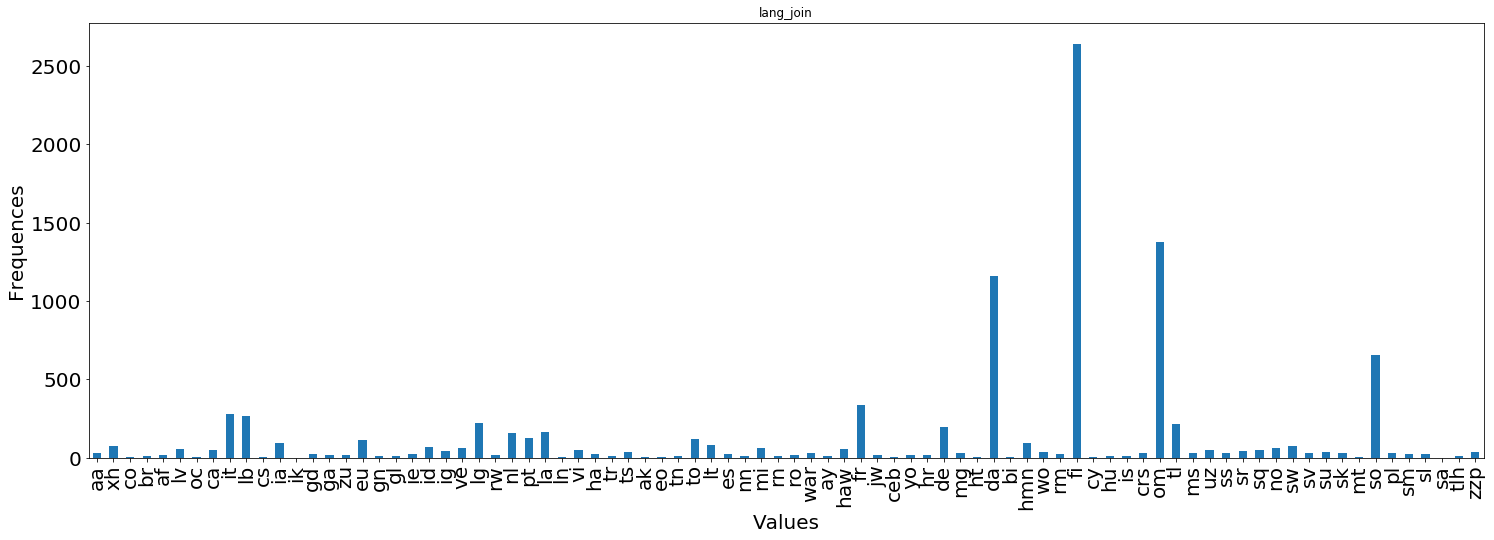

In [254]:
# Check amount of not 'en' or 'et' language in not-empty joined text

langs = useful_data['lang_join'].unique()
dict_lang = {}
for i in range(len(useful_data['lang_join'])):
    if useful_data['lang_join'][i] not in ['None', 'et', 'en']:
        if useful_data['lang_join'][i] not in dict_lang.keys():
            dict_lang[useful_data['lang_join'][i]] = 0
        dict_lang[useful_data['lang_join'][i]] += 1
df = pd.DataFrame({'col':dict_lang.keys(), 'col2':dict_lang.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "lang_join", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

In [269]:
size = 0
for i in dict_lang.values():
    size += i
float(size)/(len(useful_data['lang_join']) - len(useful_data['lang_join'][useful_data['lang_join'] == 'None']))*100

3.0072988297744

In [279]:
# Only 3% of non-empty joined text have not 'en' or 'et' languages, so we can skip them

selected_data = useful_data.loc[useful_data['lang_join'].isin(['en', 'et'])]
float(len(selected_data))/len(useful_data)*100

71.44897977320393

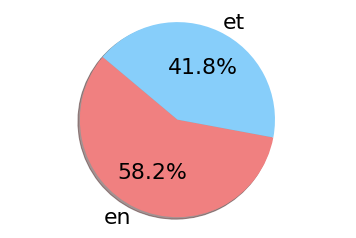

In [290]:
# Distribution of 'en' and 'et' languages

labels = 'en', 'et'
sizes = [float(len(selected_data['lang_join'][selected_data['lang_join'] == 'en']))/len(selected_data['lang_join'])*100, float(len(selected_data['lang_join'][selected_data['lang_join'] == 'et']))/len(selected_data['lang_join'])*100]
colors = ['lightcoral', 'lightskyblue']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [299]:
# Check lengthes of texts of both languages in 'text_join'

dict_lens = {}
dict_lens['en'] = 0
dict_lens['et'] = 0
counter_en = 0
counter_et = 0
for i in range(len(selected_data['lang_join'])):
    lang_to_check = selected_data.iloc[i]['lang_join']
    text_to_join = selected_data.iloc[i]['text_join']
    number_of_words = tokenizer.tokenize(str(text_to_join))
    if lang_to_check  == 'et':
        dict_lens['et'] += len(number_of_words)
        counter_et += 1
    if lang_to_check  == 'en':
        dict_lens['en'] += len(number_of_words)
        counter_en += 1
dict_lens['en'] = float(float(dict_lens['en'])/counter_en)
dict_lens['et'] = float(float(dict_lens['et'])/counter_en)
dict_lens

{'en': 10.527682317415355, 'et': 10.044189091686485}

In [ ]:
df = pd.DataFrame({'col':dict_lens.keys(), 'col2':dict_lens.values()})
df.plot.bar('col', 'col2', figsize=(25, 8), title = "lang_join", legend=False, fontsize=20)
plt.xlabel("Values", fontsize=20)
plt.ylabel("Frequences", fontsize=20)
plt.xticks(rotation=90)
plt.show()

In [286]:
# now we have 71% of all product, with joined text language Estonian or English

selected_data.to_csv("selected_data_with_joined_text_column.csv")
# selected_data = pd.read_csv("selected_data_with_joined_text_column.csv")